# Comparing proposed congressional district plans in North Carolina

November 21, 2019

There have been several redistricting cases happening in North Carolina in recent months. After a 3-judge panel ruled that the state legislative maps were an [unconsitutional partisan gerrymander](https://www.dukechronicle.com/article/2019/09/north-carolina-court-state-legislature-maps-unconstitutional-duke-mattingly-gerrymandering), the state legislature drew new maps. As the same 3 judges approved these newly drawn maps, they also [ruled that a new congressional map](https://www.wbtv.com/2019/10/28/nc-judges-approve-legislative-maps-rule-against-congressional-maps-elections/) must be drawn before the 2020 election. 

During the process of drawing new legislative or congressional maps, it is a constant challenge to assess the "fairness" of the proposed plans. In the case of the most recent congressional redistricting, the state legislature uploaded various files of proposed plans. It's important for the redistricting process to be made public to allow the people who are actually living in the districts to voice their opinions on which plans they think are most fair. **This notebook demonstrates how to work with these files (called shapefiles) to analyze the proposed plans, with the hope of enabling more people to be equipped to hold map-makers accountable for the plans they draw.**

The NC legislature has already [approved a new congressional map](http://www.ncpolicywatch.com/2019/11/19/the-gops-latest-gerrymander-ought-to-be-the-last-straw-for-nc/); however, this type of analysis is useful to see where the selected plan compares to the proposed plans that were not selected, and also to be used as a starting point for use in future redistricting cycles (in any state).

This notebook demonstrates how to: <br>
**1. Read in multiple shapefiles for easy comparison**: show how to go from zipped files that may be downloaded from a state's legislative website into geopandas dataframes <br>
**2. Work with geopandas dataframes**: create maps, aggregate votes from past elections into new districts, run metrics for quantifying gerrymandering

If you would just like to use the shapefiles I've used, you can skip part 1 and just use the data I've uploaded to this repository directly. Part 1 will be useful if you want to be able to analyze a different set of shapefiles than the ones I have provided in this repository.

First make sure you have all required packages installed and imported:

In [1]:
import maup
import geopandas as gpd
import pandas as pd
import os
import shutil
import numpy as np
from PyPDF2 import PdfFileMerger, PdfFileReader
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

# 1. Reading in shapefiles

### Election results shapefile
If you wanted to re-create this for another state, you can dowload past election results (at the precinct level) from [OpenPrecincts](https://openprecincts.org/nc/). You would just need to download and unzip the appropriate .zip file (from the "Download Shapefile" button) and replace the file path ("NC Congressional Redistricting data") with wherever you save the file on your machine. Unfortunately, this precinct-level data is currently only available for a few states due to the lack of consistency in how states report election results. See [OpenPrecincts](https://openprecincts.org/) for more information.

For simplicity's sake, I've uploaded this file into the folder "NC Congressional Redistricting data" that's available in this repo.

In [237]:
#load in precincts shapefile
precincts = gpd.read_file("NC Congressional Redistricting data/NC_G18.shp")
precincts.head()

PREC_ID              ENR_DESC COUNTY_NAM OF_PREC_ID  COUNTY_ID  \
0     06N      06N_NORTH GRAHAM   ALAMANCE       None          1   
1    1210    1210_BURLINGTON 10   ALAMANCE       None          1   
2     06E       06E_EAST GRAHAM   ALAMANCE       None          1   
3     063          063_GRAHAM 3   ALAMANCE       None          1   
4     12N  12N_NORTH BURLINGTON   ALAMANCE       None          1   

        loc_prec       prec_shp  G18CStHOR  G18CStSen  G18CHOR  ...  \
0   ALAMANCE,06N   ALAMANCE,06N          0          0        0  ...   
1  ALAMANCE,1210  ALAMANCE,1210          0          0        0  ...   
2   ALAMANCE,06E   ALAMANCE,06E          0          0        0  ...   
3   ALAMANCE,063   ALAMANCE,063          0          0        0  ...   
4   ALAMANCE,12N   ALAMANCE,12N          0          0        0  ...   

   G18GStHOR  G18GHOR  G18LStHOR  G18LStSEN  G18LHOR  G18RStHOR  G18RStSEN  \
0          0        0          0          0        0        312        335   
1          0        0          0          0        0        393        410   
2          0        0          0          0        0        527        566   
3          0        0          0          0        0        365        370   
4          0        0          0          0        0        192        196   

   G18RHOR  G18UnaHOR                                           geometry  
0      344          0  POLYGON ((1884558.649606138 851226.325625971, ...  
1      421          0  POLYGON ((1867094.975872144 842884.0693446398,...  
2      572          0  POLYGON ((1885497.823580801 846796.6756926477,...  
3      386          0  POLYGON ((1885054.110557467 851287.3586403877,...  
4      203          0  POLYGON ((1872167.538561642 854095.3789429814,...  

[5 rows x 23 columns]

So this geodataframe `precincts` has a row for each of the 2706 precincts in NC and columns for the vote totals by party for each of the 3 races (US House, NC House, NC Senate).

### Proposed plan shapefiles 

Again, for convenience, I've uploaded all the proposed district maps to the `NC Congressional Redistricting data` folder of this repository. If you want to use these files, you can **skip this section and go straight to the next section.**

This function enables you to read in a file given the file name and a label to call the plan once it's read in as a Geopandas dataframe. We'll then use a loop to read in all the shapefiles you have saved in a directory. 

To reproduce this process, go to [the Documents page of the redistricting committee's page](https://www.ncleg.gov/Committees/CommitteeInfo/House/182#Documents). Choose a day (e.g. "11-13-19"), choose a plan (e.g. "HB 1029 1st Edition"), then download the file ending with "-Shapefile" and unzip it. Keep all these folders in your Downloads folder to read through. We'll move them to a different folder for permanent access.

I'll also include the current congressional map, which is to be replaced. It can be downloaded from [ncleg.gov](https://www3.ncleg.gov/Representation/Content/Plans/PlanPage_DB_2016.asp?Plan=2016_Contingent_Congressional_Plan_-_Corrected&Body=Congress). At the bottom of this page under "FILES FOR DOWNLOAD", download the zip file next to "District Layer in Shapefile Format". Then unzip and rename this folder so that it ends in "Shapefile" (to match the rest of the downloaded files) and place it in the same Downloads directory.

For NC, each shapefile was contained within it's own folder, so instead of going through and manually moving the contents of each folder into the same permanent folder, I wrote the following code to do this for me. This would only be useful if you want to download several plans (besides the one's I've done) and compare them.

In [ ]:
#destinationFolder = "NC Congressional Redistricting data/"
#folderList = os.listdir("/Users/rachelwitner/Downloads/")
#for folder in folderList:
#    if "Shapefile" in folder:
#        # move all files in folder to PGP data folder
#        files = os.listdir("/Users/rachelwitner/Downloads/" + folder)
#        for file in files:
#            os.rename("/Users/rachelwitner/Downloads/" + folder + "/" + file, destinationFolder+file)

In [286]:
#list variables you want to aggreage into districts
variables = ['G18CStHOR', 'G18CStSen', 'G18CHOR','G18DStHOR', 'G18DStSEN', 'G18DHOR', 'G18GStHOR', 'G18GHOR',
             'G18LStHOR', 'G18LStSEN', 'G18LHOR', 'G18RStHOR', 'G18RStSEN','G18RHOR', 'G18UnaHOR']

# function to read in a file with districts and sum votes by district
def load_district_shapefile(fname, label):
    thisfile = gpd.read_file("NC Congressional Redistricting data/" + fname)
    thisfile.crs={'init': 'epsg:32119'} # initialize crs in case there is none
    thisfile = thisfile.to_crs(precincts.crs) # convert to the same crs as precincts
    
    #make district assignment for every precinct
    assignment = maup.assign(precincts, thisfile)

    #sum votes by district
    thisfile[variables] = precincts[variables].groupby(assignment).sum()
    
    files[label] = thisfile

In [296]:
# create dictionary (files) of district geopandas files
files = {}
fileList = os.listdir("NC Congressional Redistricting data")
for file in fileList:
    if file.endswith(".shp") and (file.startswith("C-") or file.startswith("2016")):
        filename = file[:-4]
        print(filename)
        load_district_shapefile(file, filename)

C-NewtonA-5-4-TC
C-HarrisonA-1-TC
C-Clark-8-6-TC
C-LewisD-1-TC
C-Clark-9-6 RN
C-HiseC-1-ND
C-Farmer-ButterfieldC-1-BK
C-McKissickB-1-TC
C-Farmer-ButterfieldA-1-3-BK
C-LewisD-1-RN
C-HiseA-4-1-TC
C-HiseA-5-BR
C-Clark-8-3-TC
C-McKissickA-1-TC
2016_Contingent_Congressional_Plan_Corrected


Now we can easily work with any of the above district geodataframes.

# 2. Working with the geodataframes

In this analysis, we consider election results from the 2018 US House race to investigate the hypothetical question: how would the 2018 election have turned out if this new map had been used? For comparison, here is a map of the districts actually used in 2018, which led to the election of 10 Republicans and 3 Democrats into North Carolina's 13 US House seats (after a [special election in district 9](https://en.wikipedia.org/wiki/2019_North_Carolina%27s_9th_congressional_district_special_election)).

This type of analysis could easily be extended to other races of interest.

In [297]:
# global settings for figure sizes
plt.rcParams["figure.figsize"] = [7,5]
plt.rcParams["figure.dpi"] = 500

# create a normalized colorbar
divnorm = colors.DivergingNorm(vmin=0, vcenter=50, vmax=100)
cbar = plt.cm.ScalarMappable(norm=divnorm, cmap='RdBu')

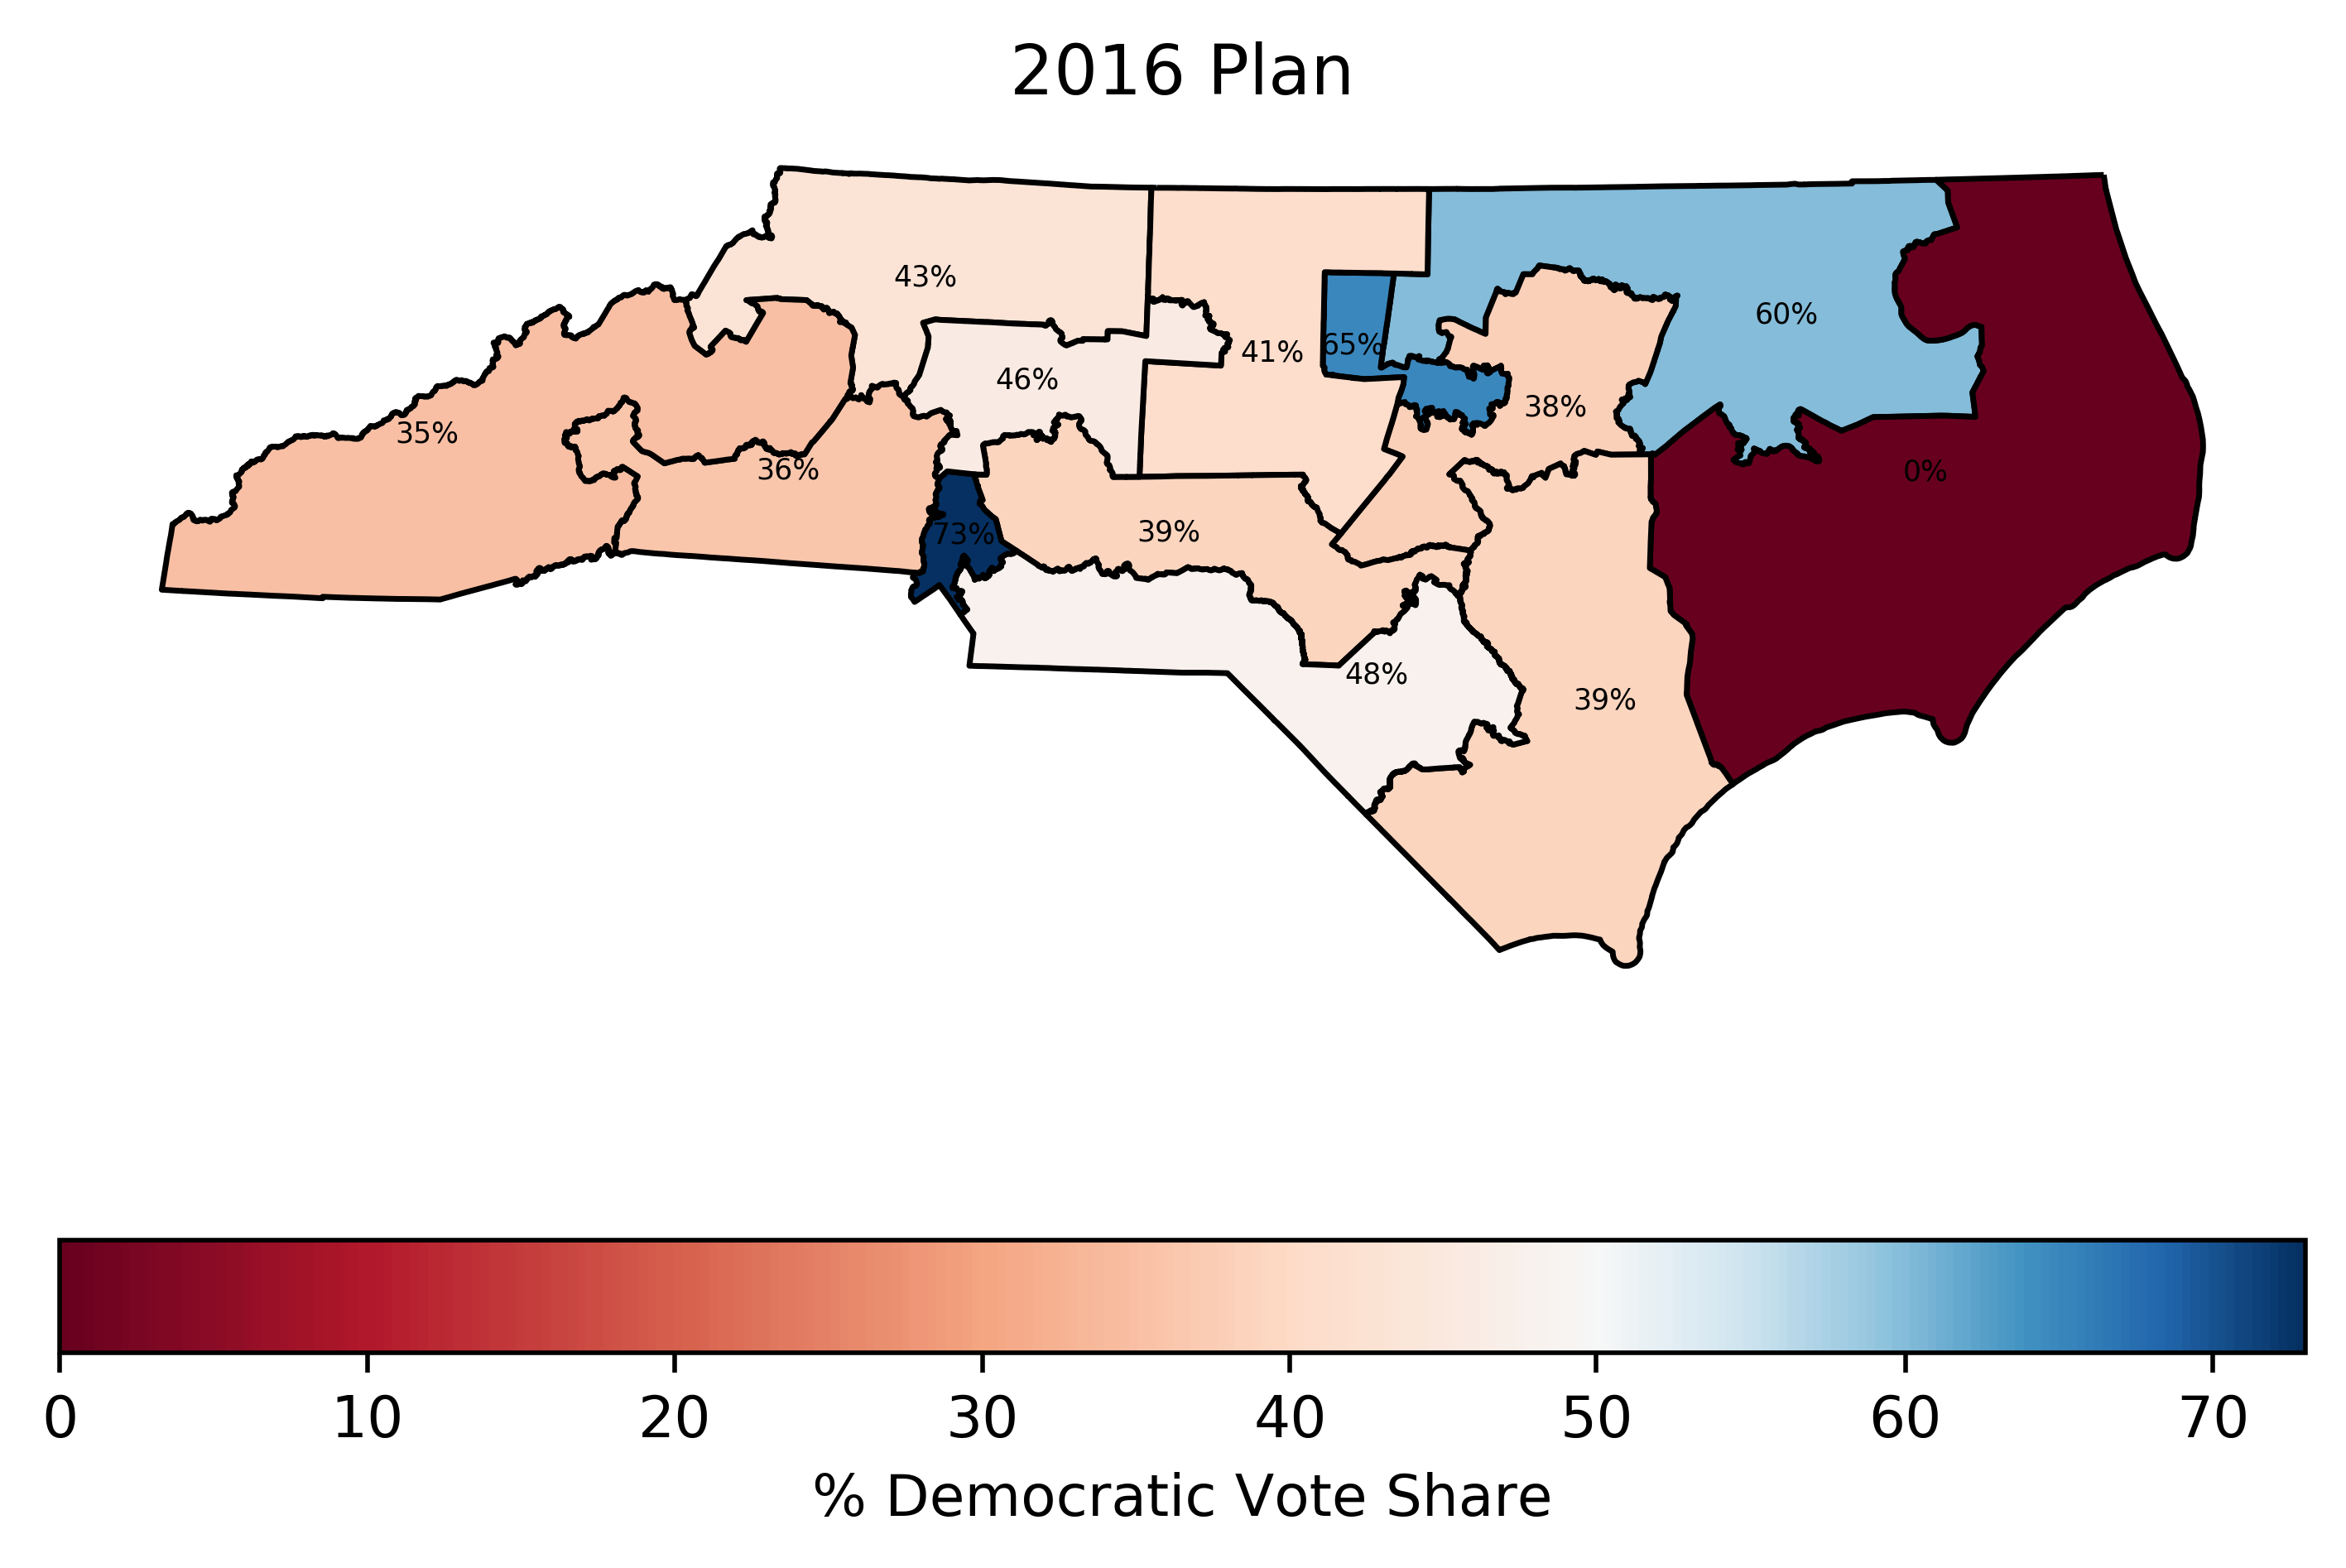

In [330]:
planName = "2016_Contingent_Congressional_Plan_Corrected"
plan = files[planName]
plan["totVotes"] = plan["G18CHOR"] + plan["G18DHOR"] + plan["G18GHOR"] + plan["G18LHOR"] + plan["G18RHOR"] + plan["G18UnaHOR"]
plan["percentDem"] = round(plan["G18DHOR"]/plan["totVotes"]*100).astype(np.int64)
plan["percentDem_discrete"] = pd.cut(plan["percentDem"], bins=[0,15,25,35,45,55,65,75,85,100], labels=["0-15","15-25","25-35","35-45","45-55","55-65","65-75","75-85","85-100"])

plan['coords'] = plan['geometry'].apply(lambda x: x.representative_point().coords[:])
plan['coords'] = [coords[0] for coords in plan['coords']]

f, ax = plt.subplots(1)
ax.set_axis_off()
plan.plot(column="percentDem", ax=ax, edgecolor='black', cmap='RdBu', norm=divnorm)
for idx, row in plan.iterrows():
    label = str(row['percentDem'])+"%"
    plt.annotate(s=label, xy=row['coords'], horizontalalignment='center', size=5)
plt.title("2016 Plan")
f.colorbar(cbar, ax=ax, label="% Democratic Vote Share", orientation='horizontal')
plt.show()

The following loop goes through each key in the dictionary called `files` and creates the same plot. For each one, create a colorbar centered at 50% to show the percent democratic vote share for each district, using the 2018 US House election results. At the end of the loop, there is an option to either display the plot, or save it to a PDF if you'd like. 

Note: the proposed House Bill map we downloaded from ncleg (HB 1029) is actually labeled as "C-NewtonA-5-4-TC". 

Also note: each district number is in parenthesis beneath the % democratic vote label, except for plans where districts were not labeled.

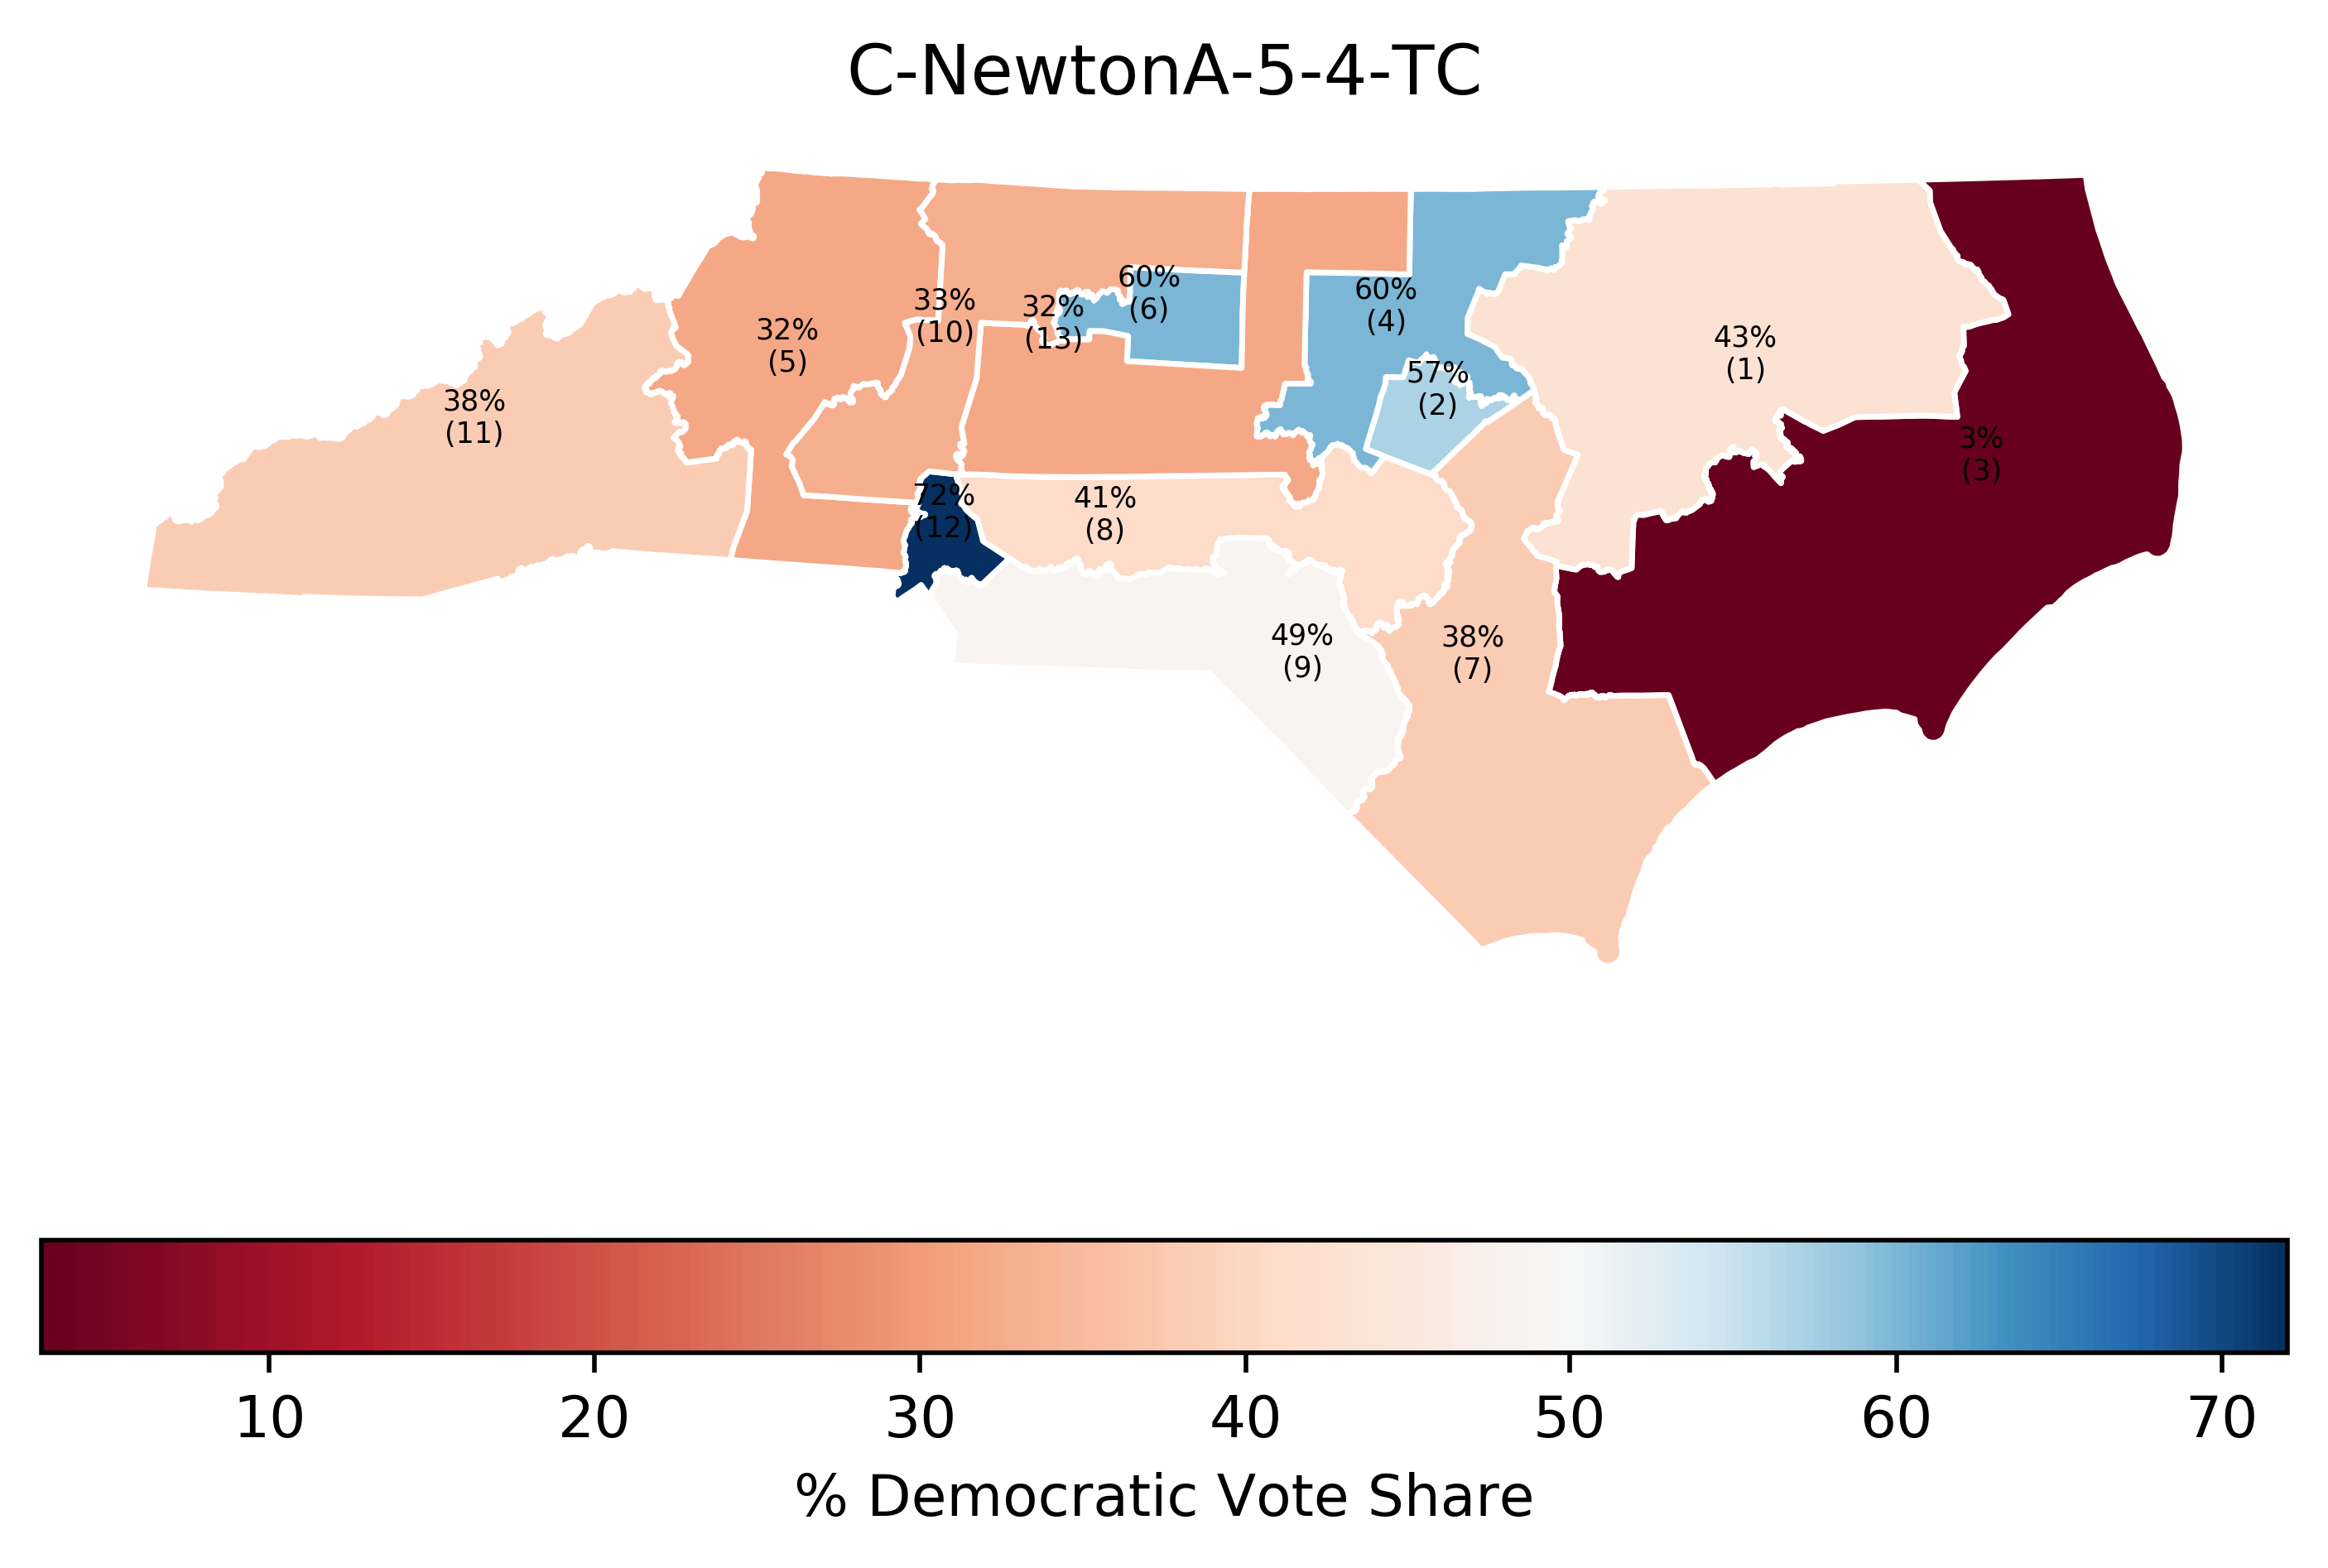

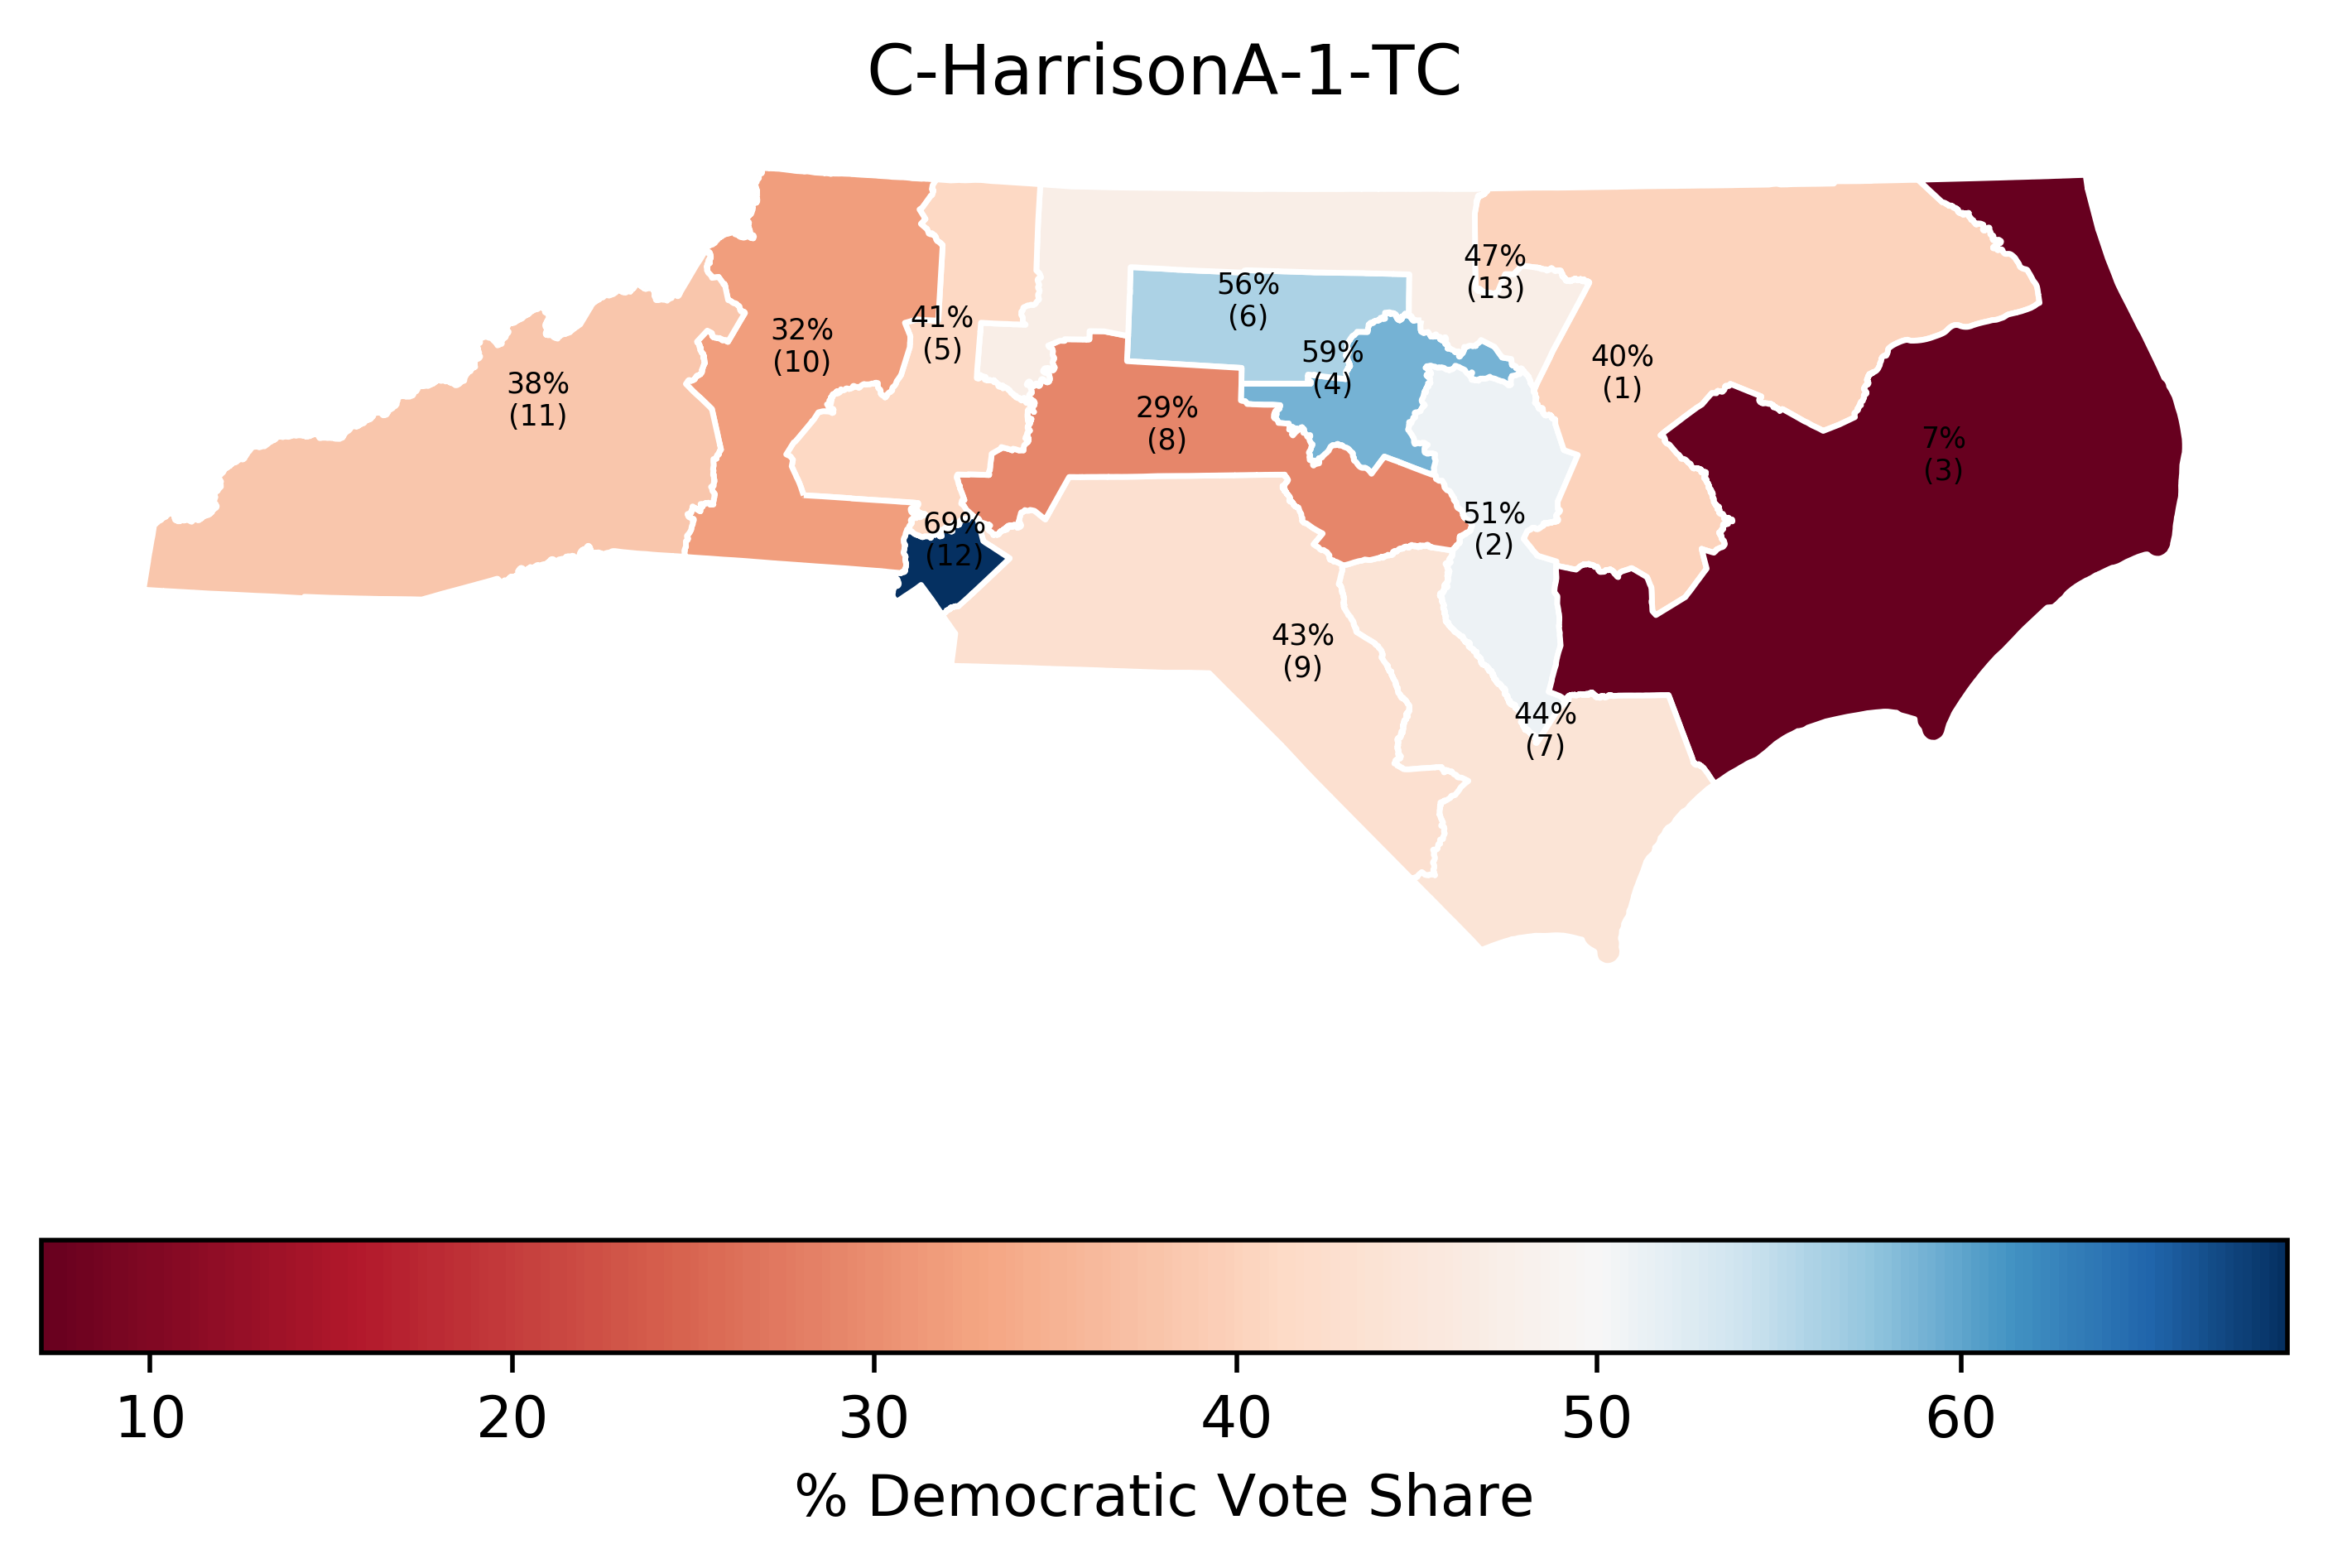

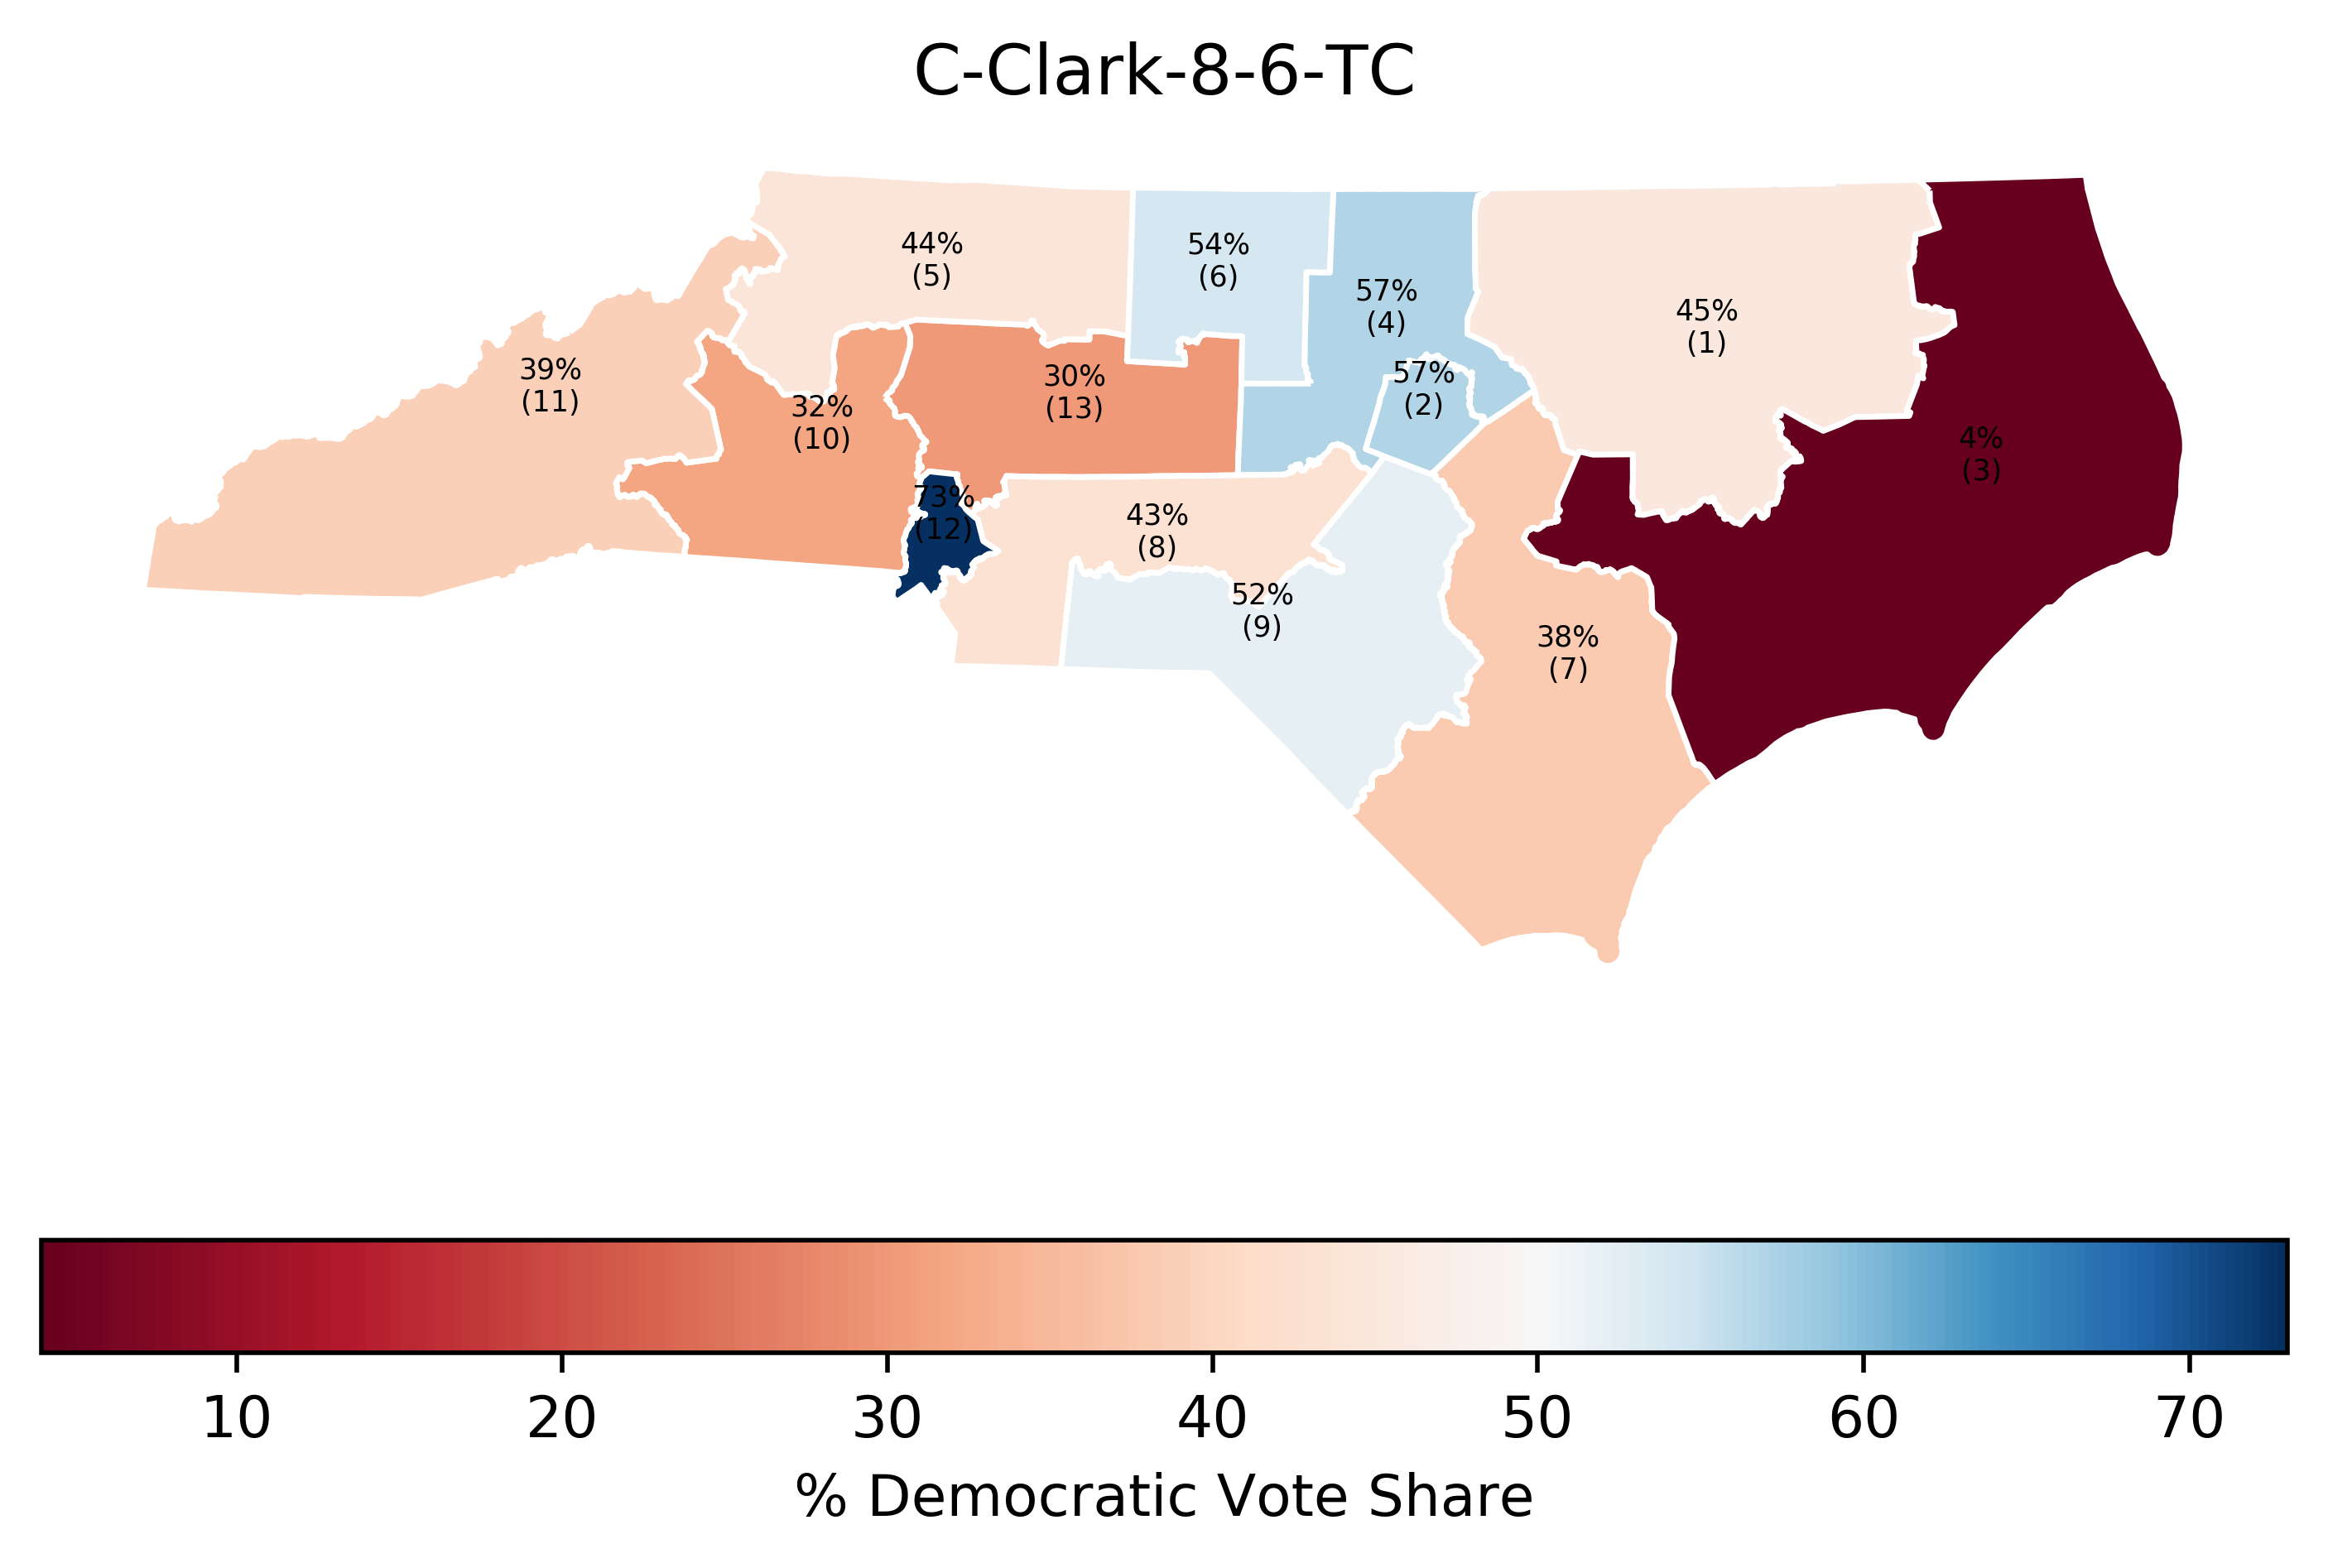

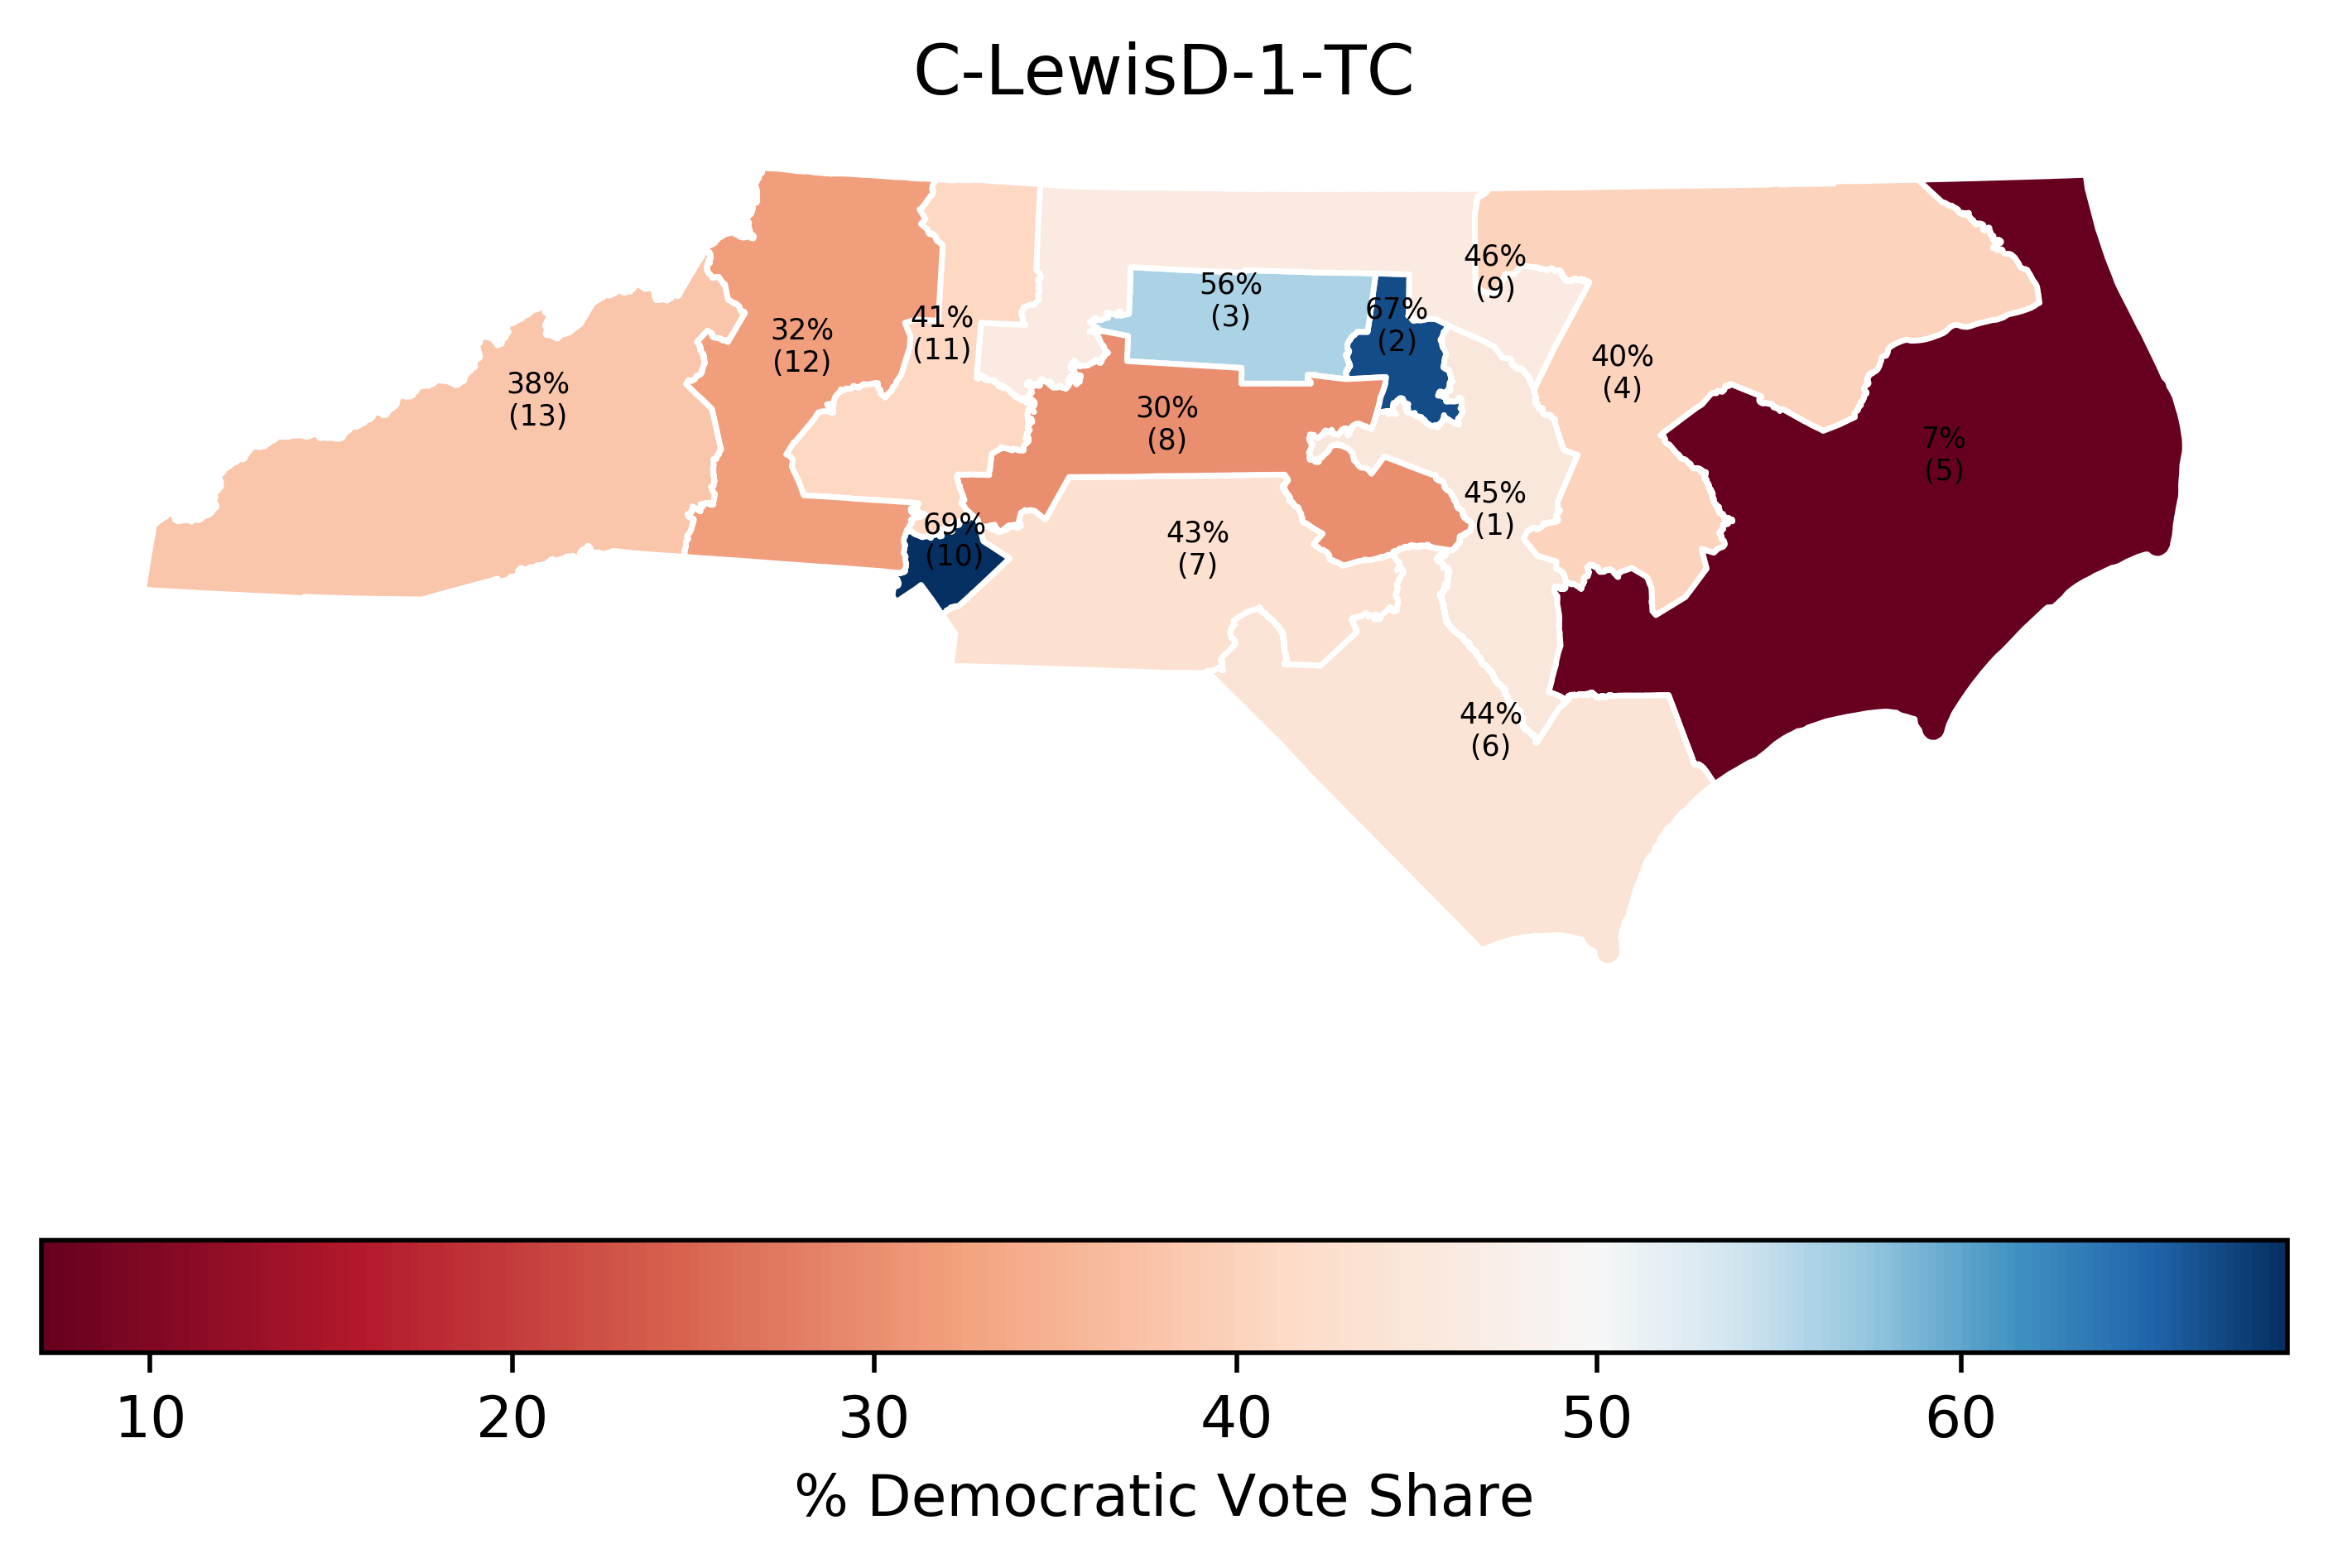

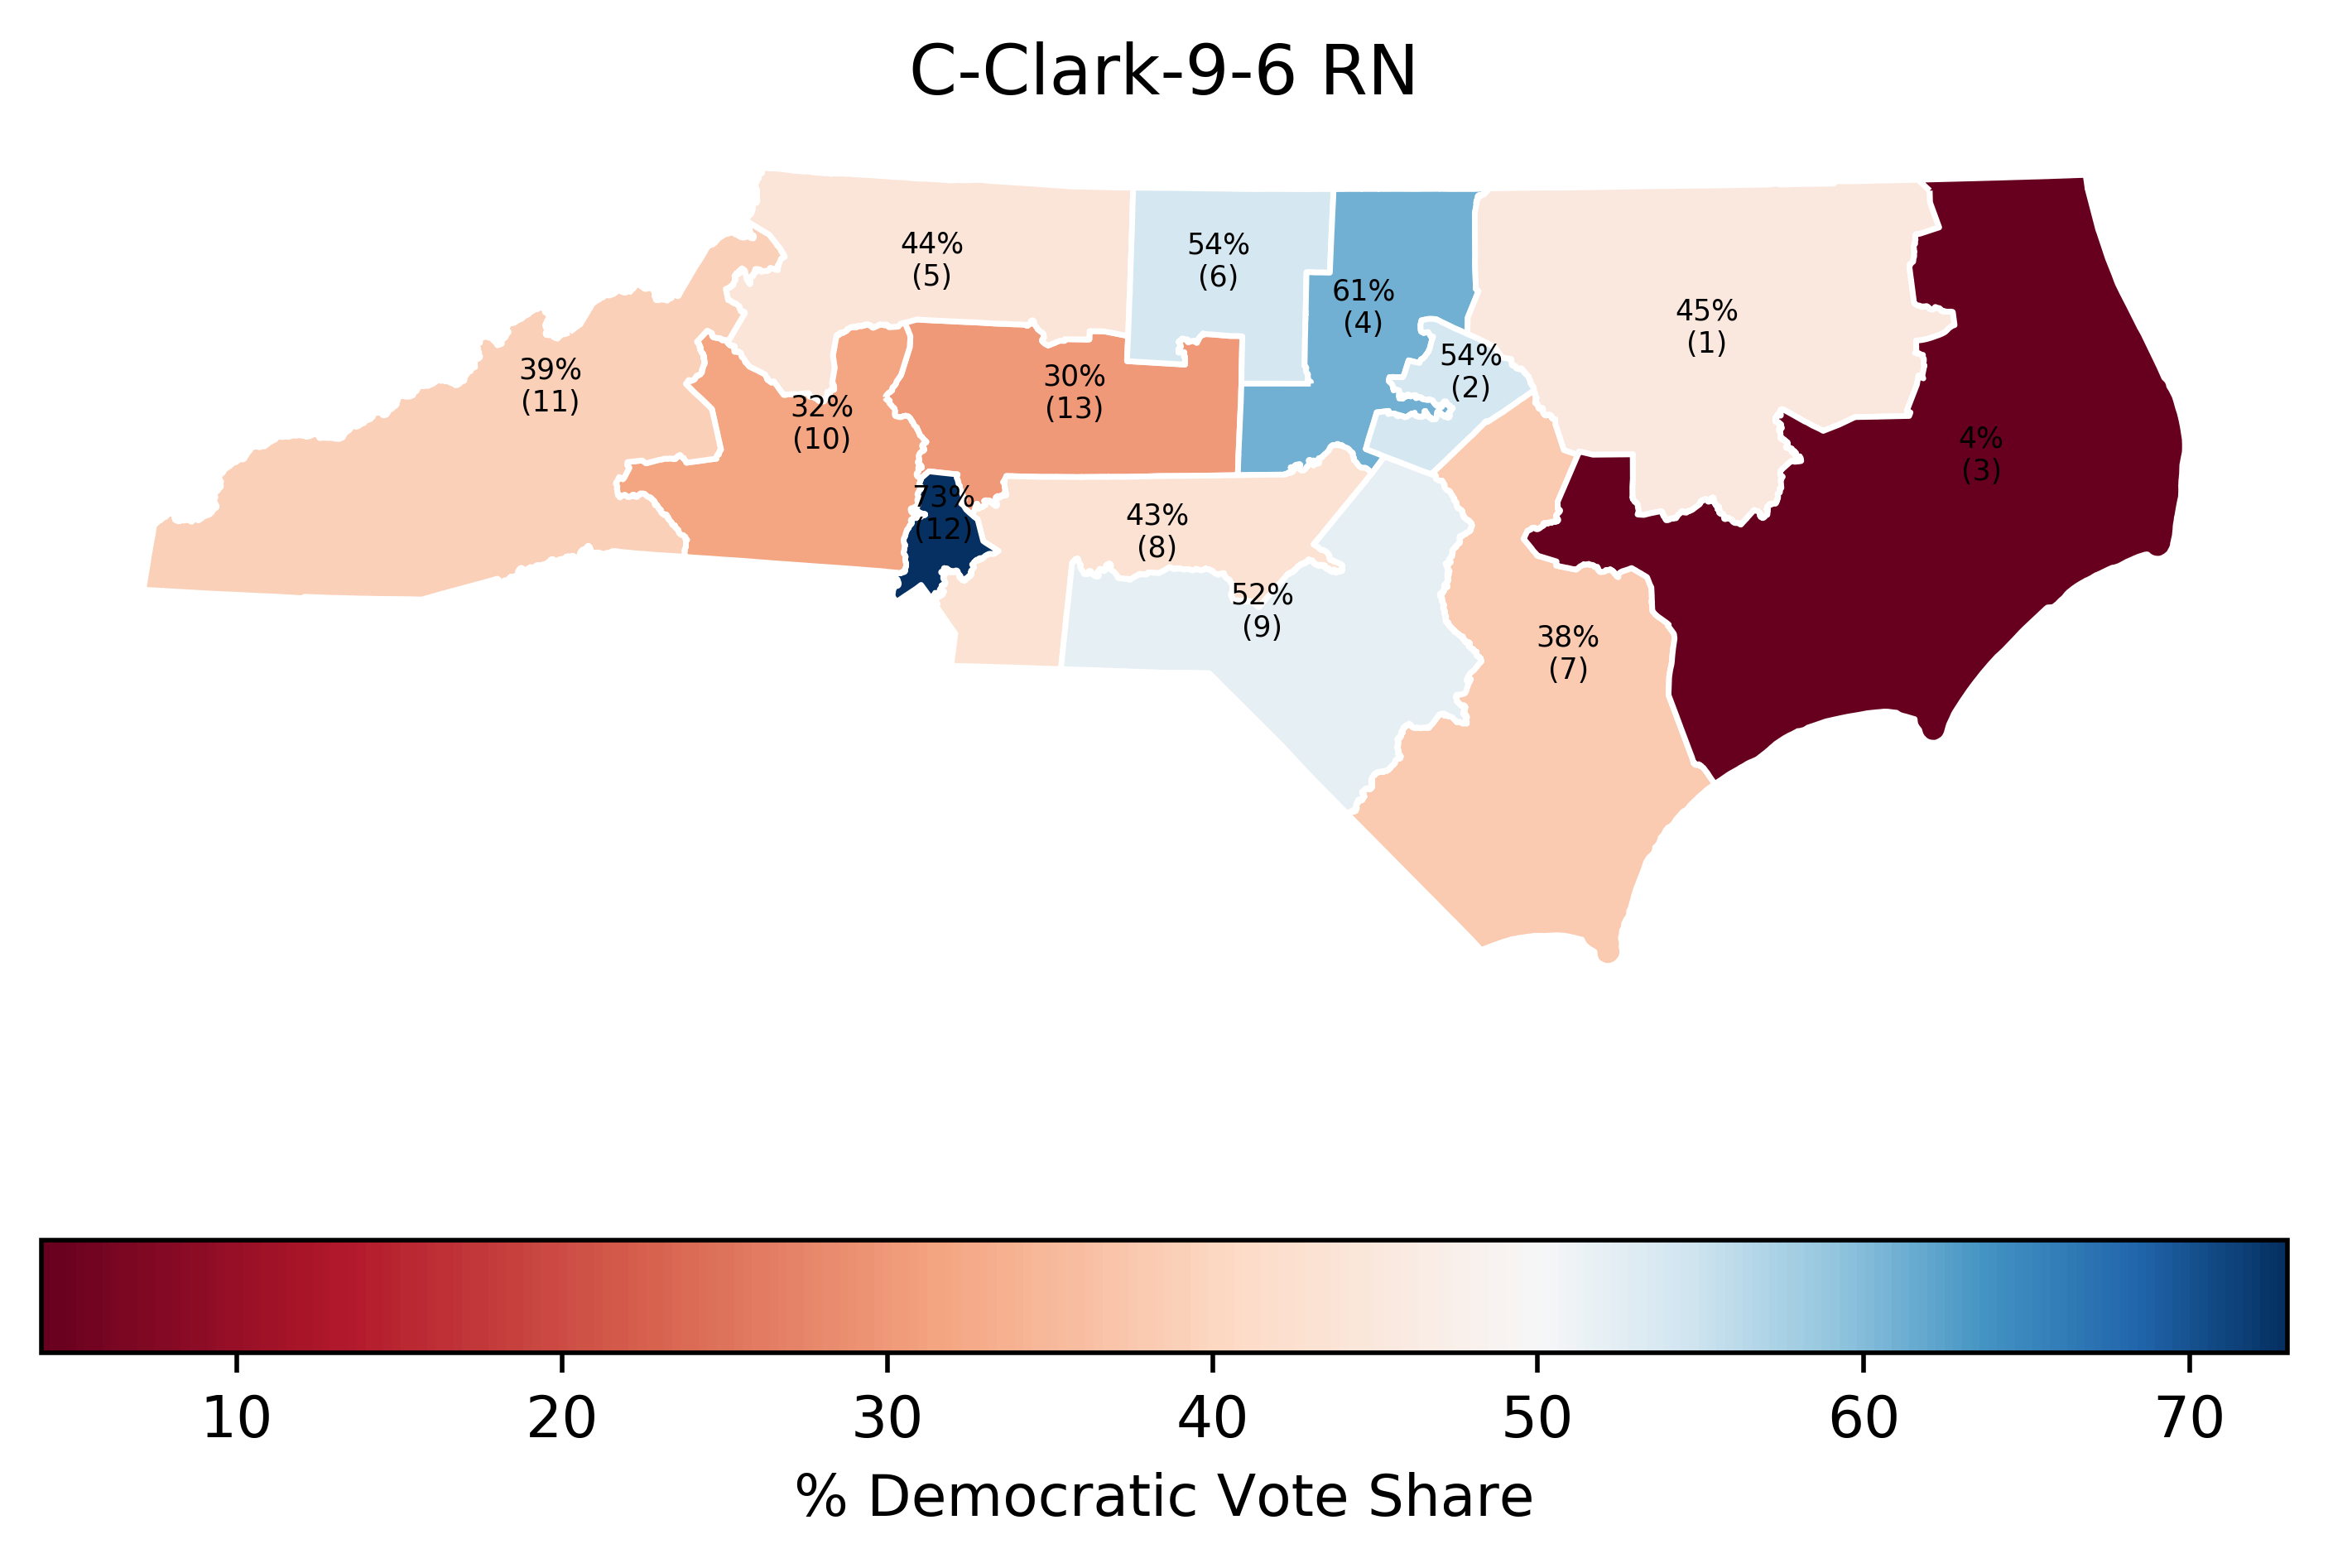

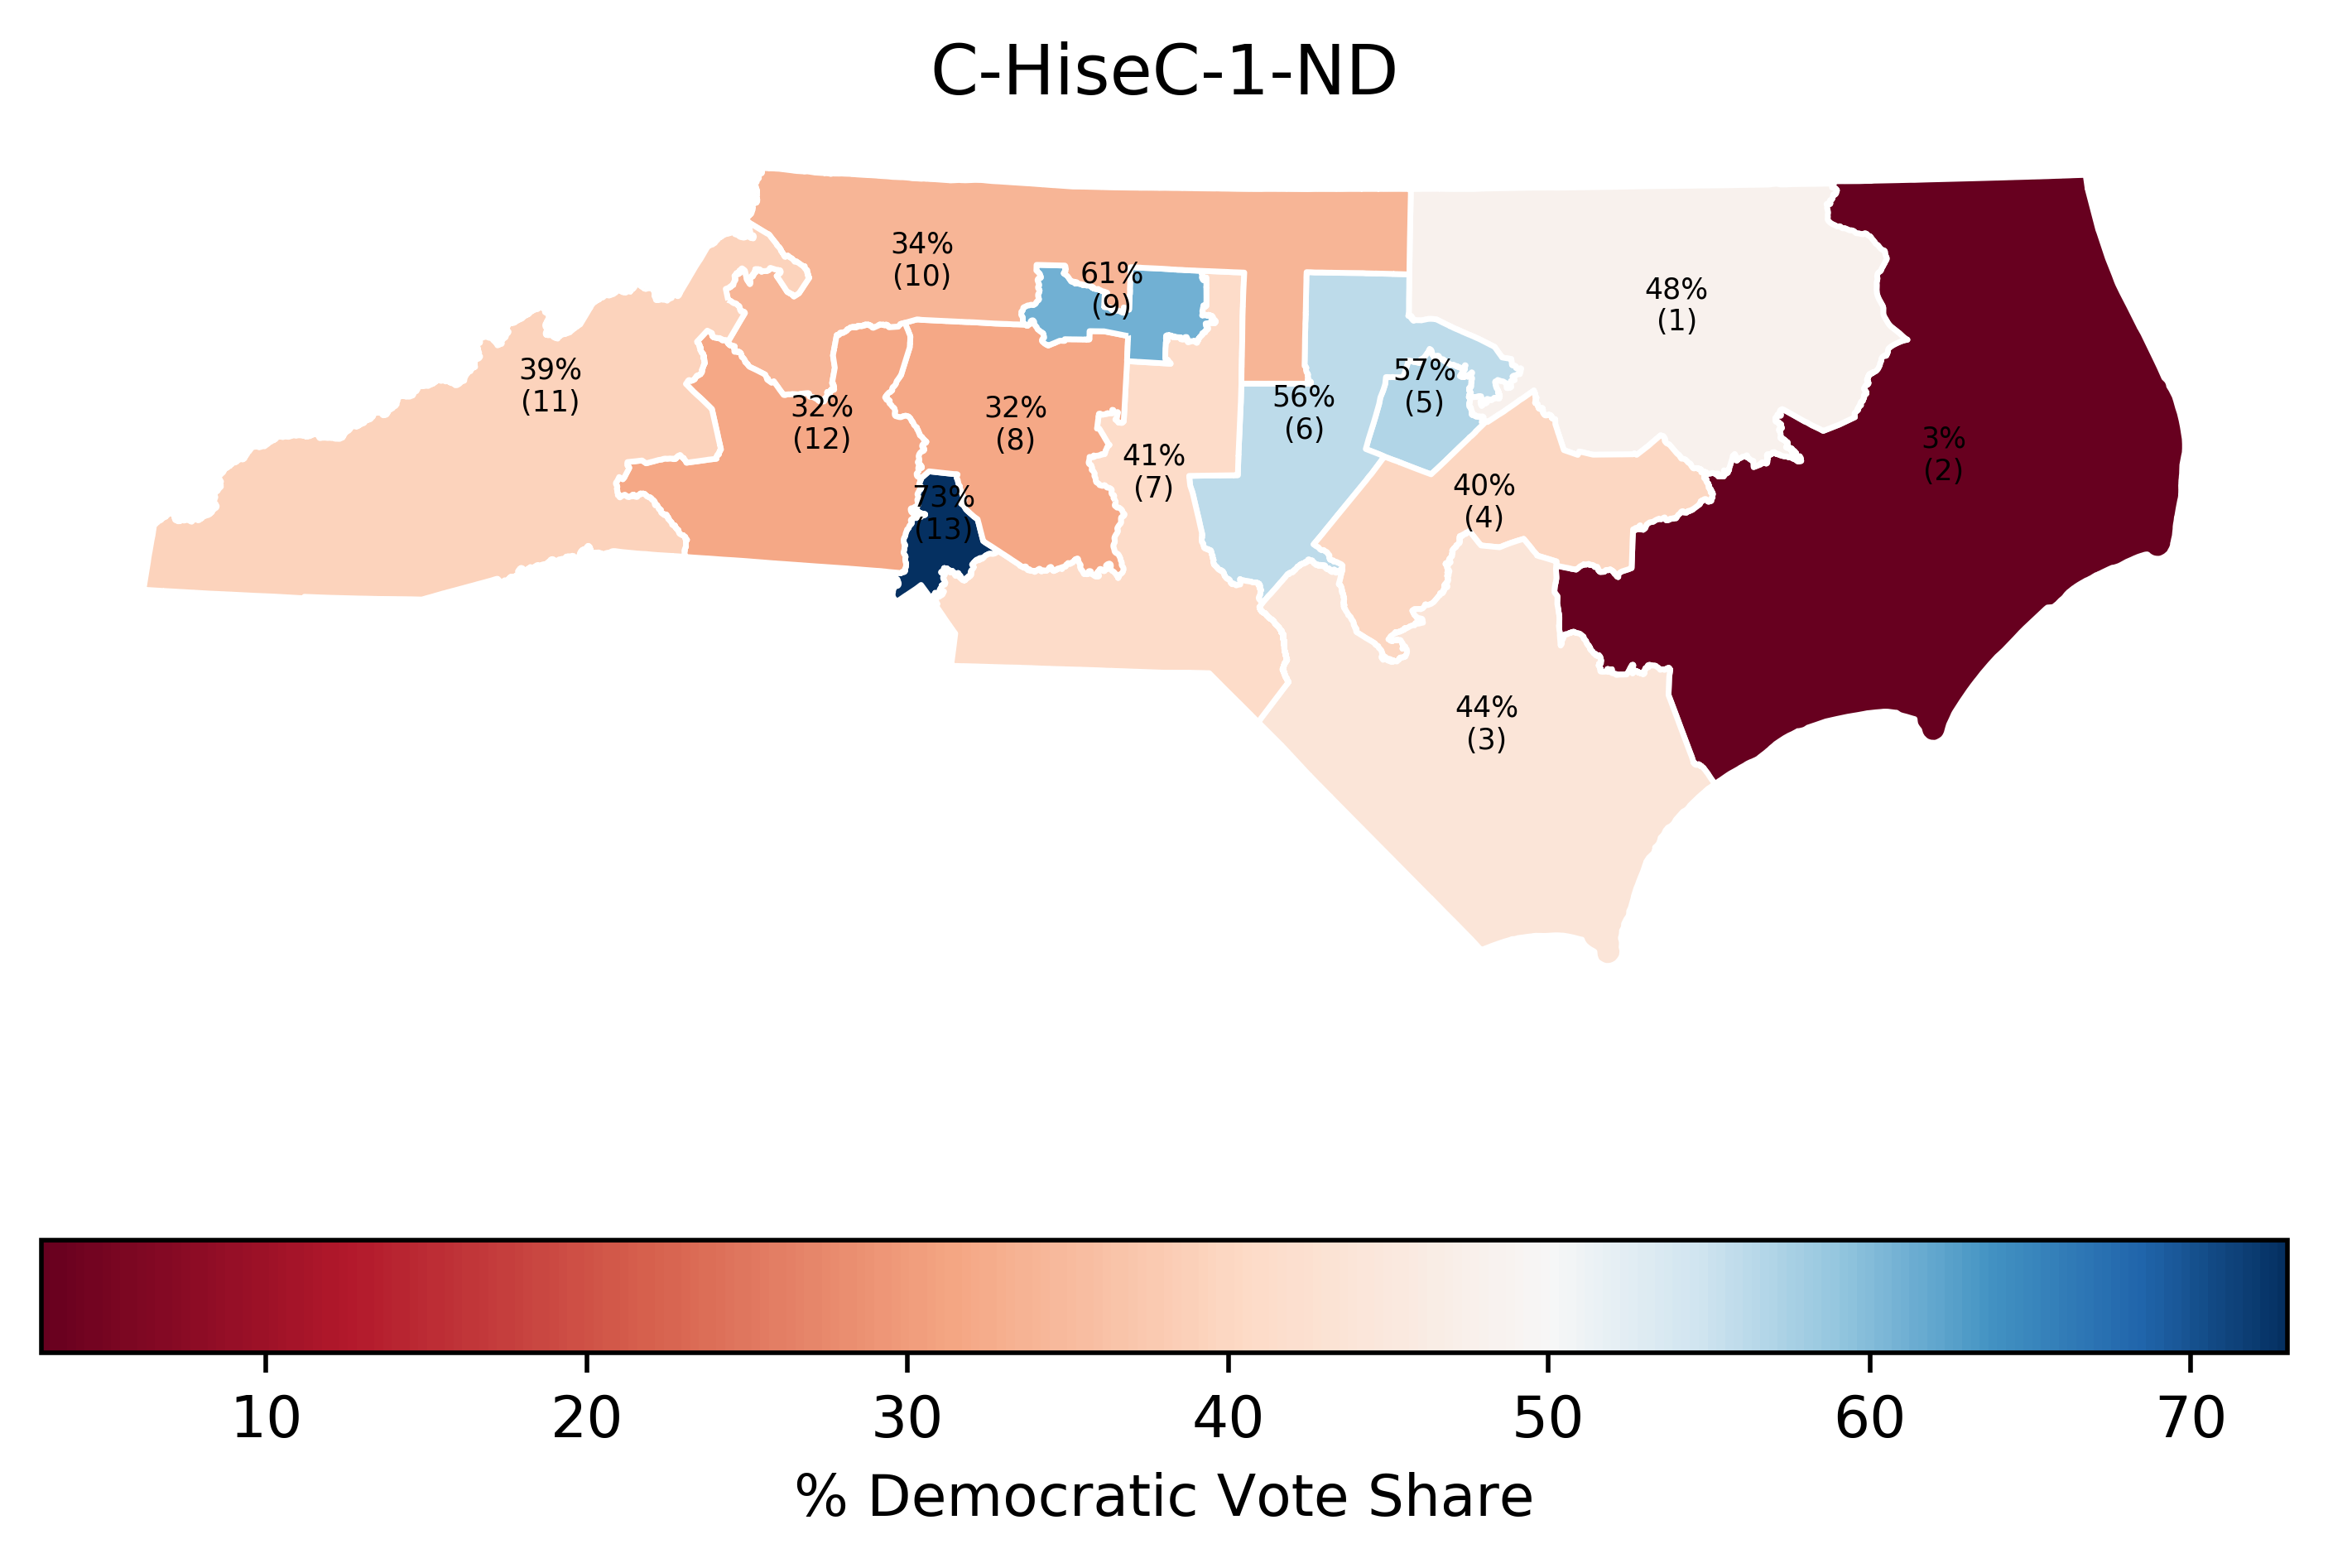

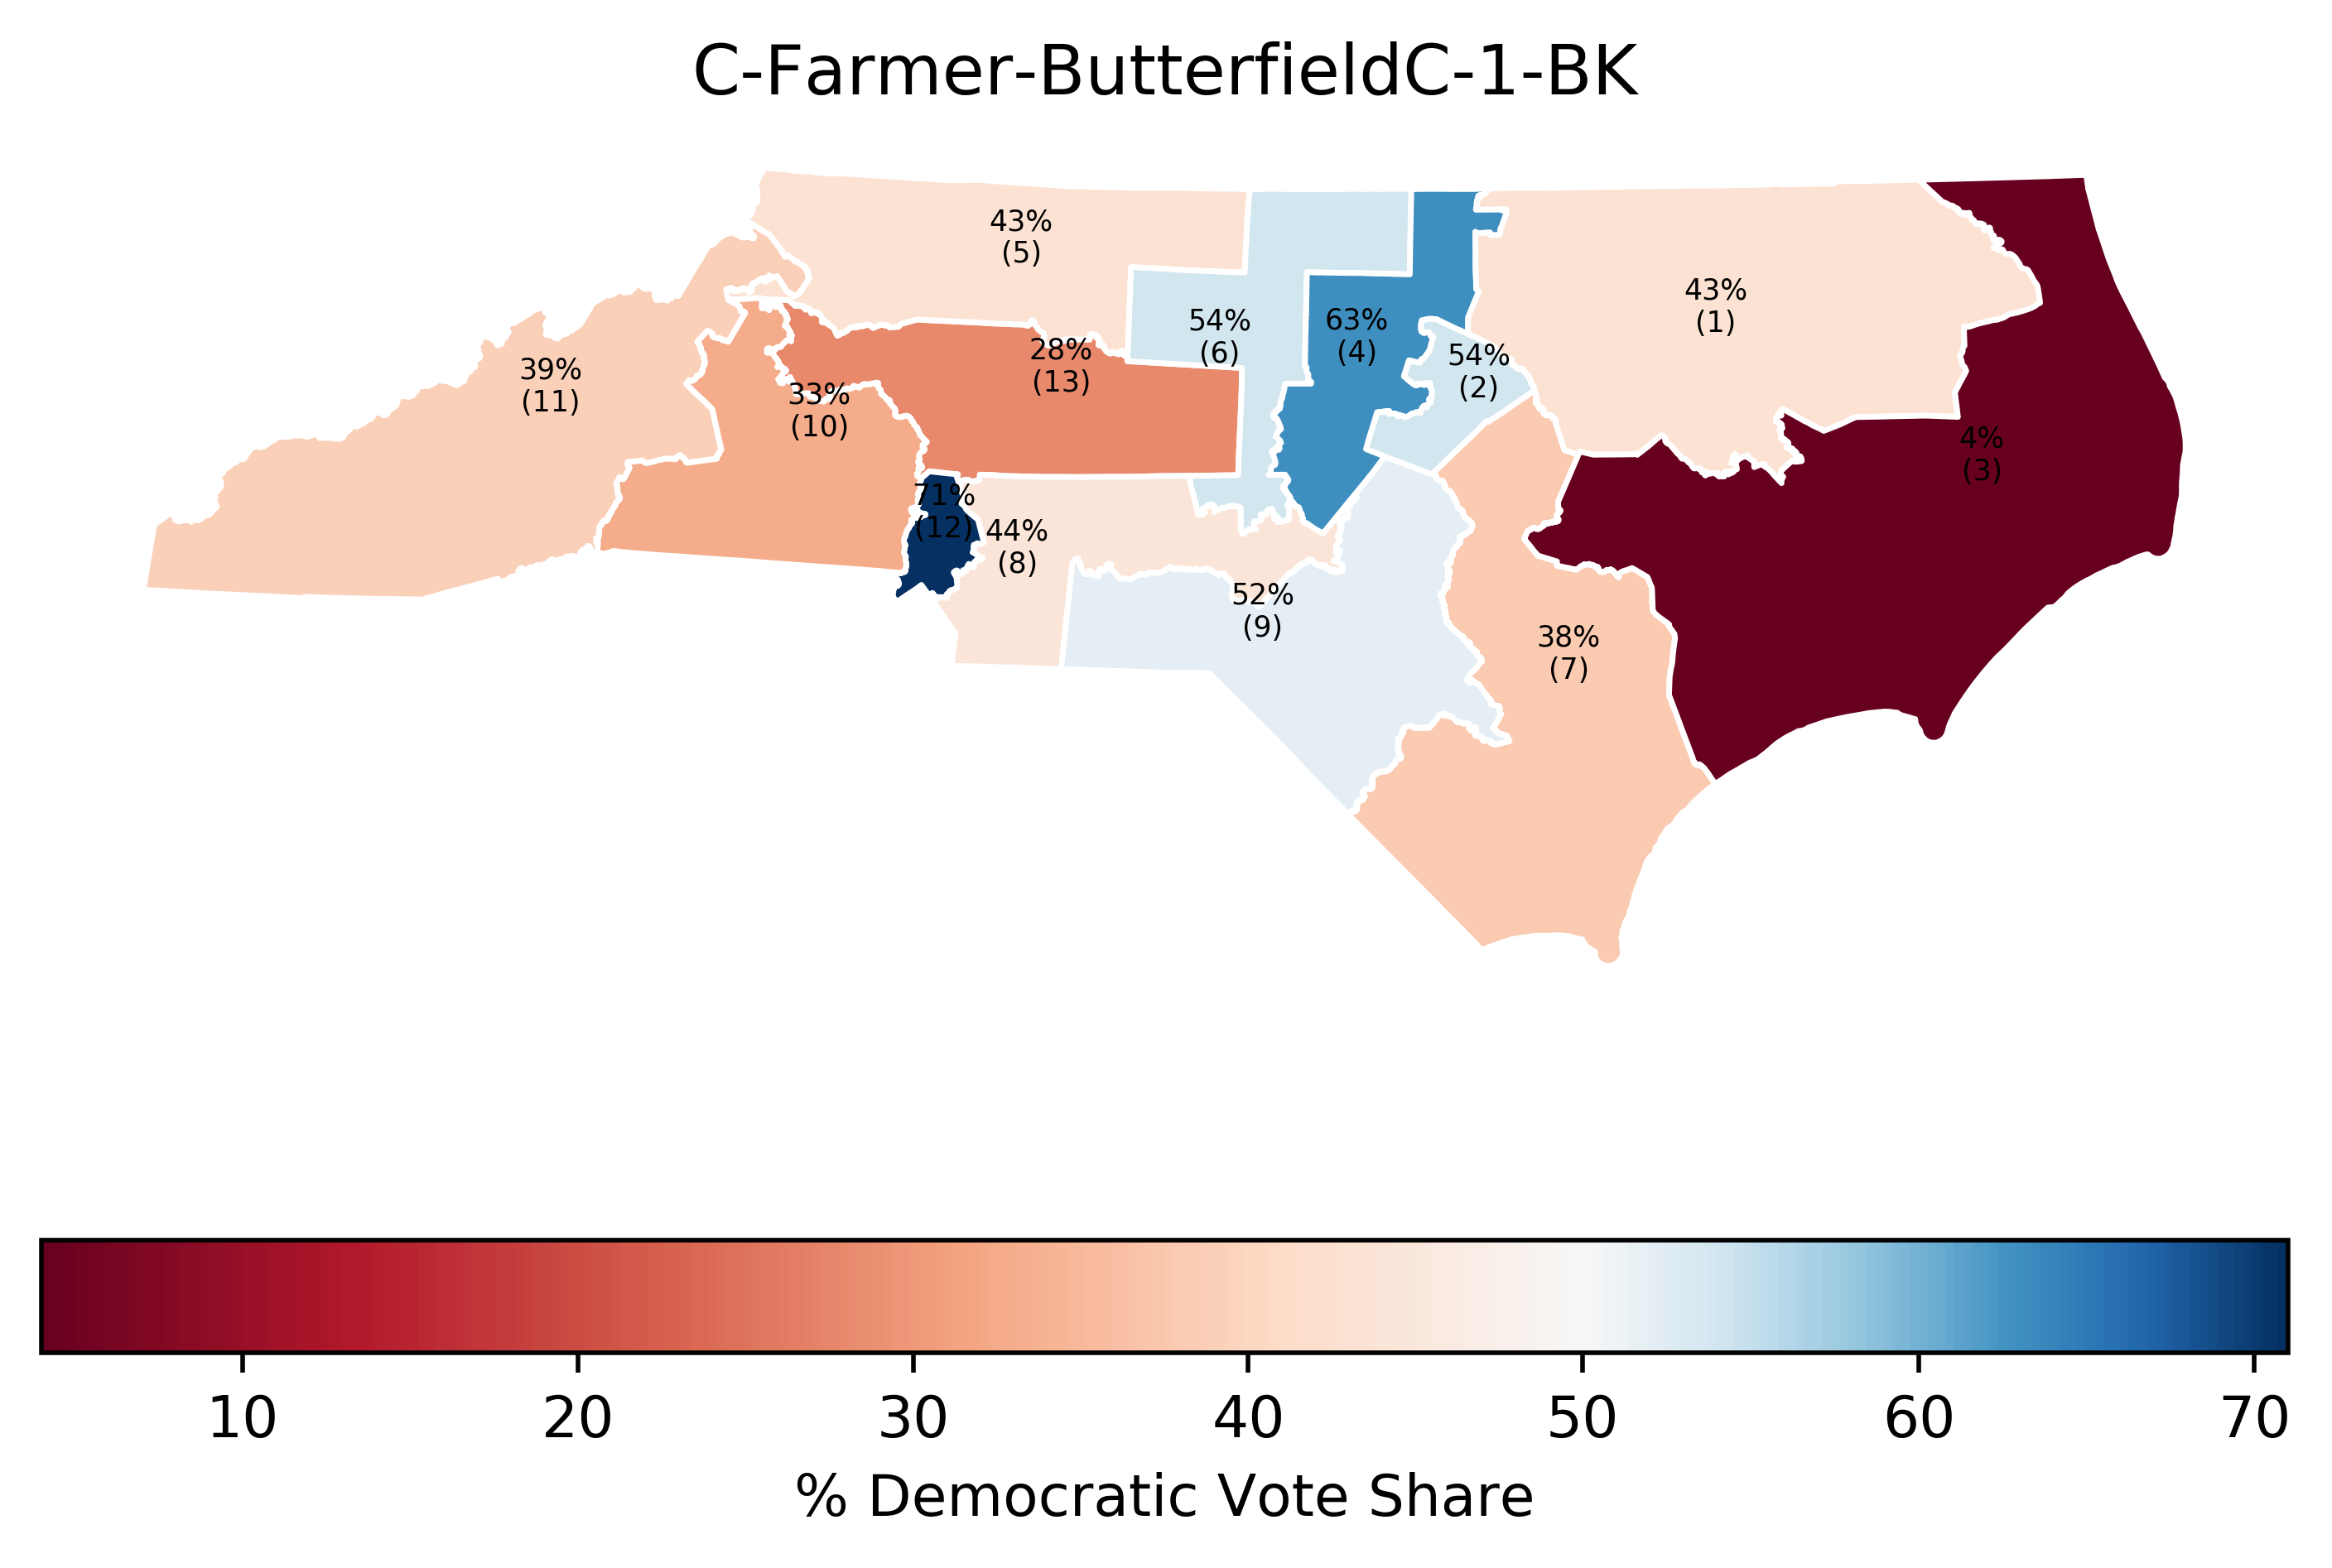

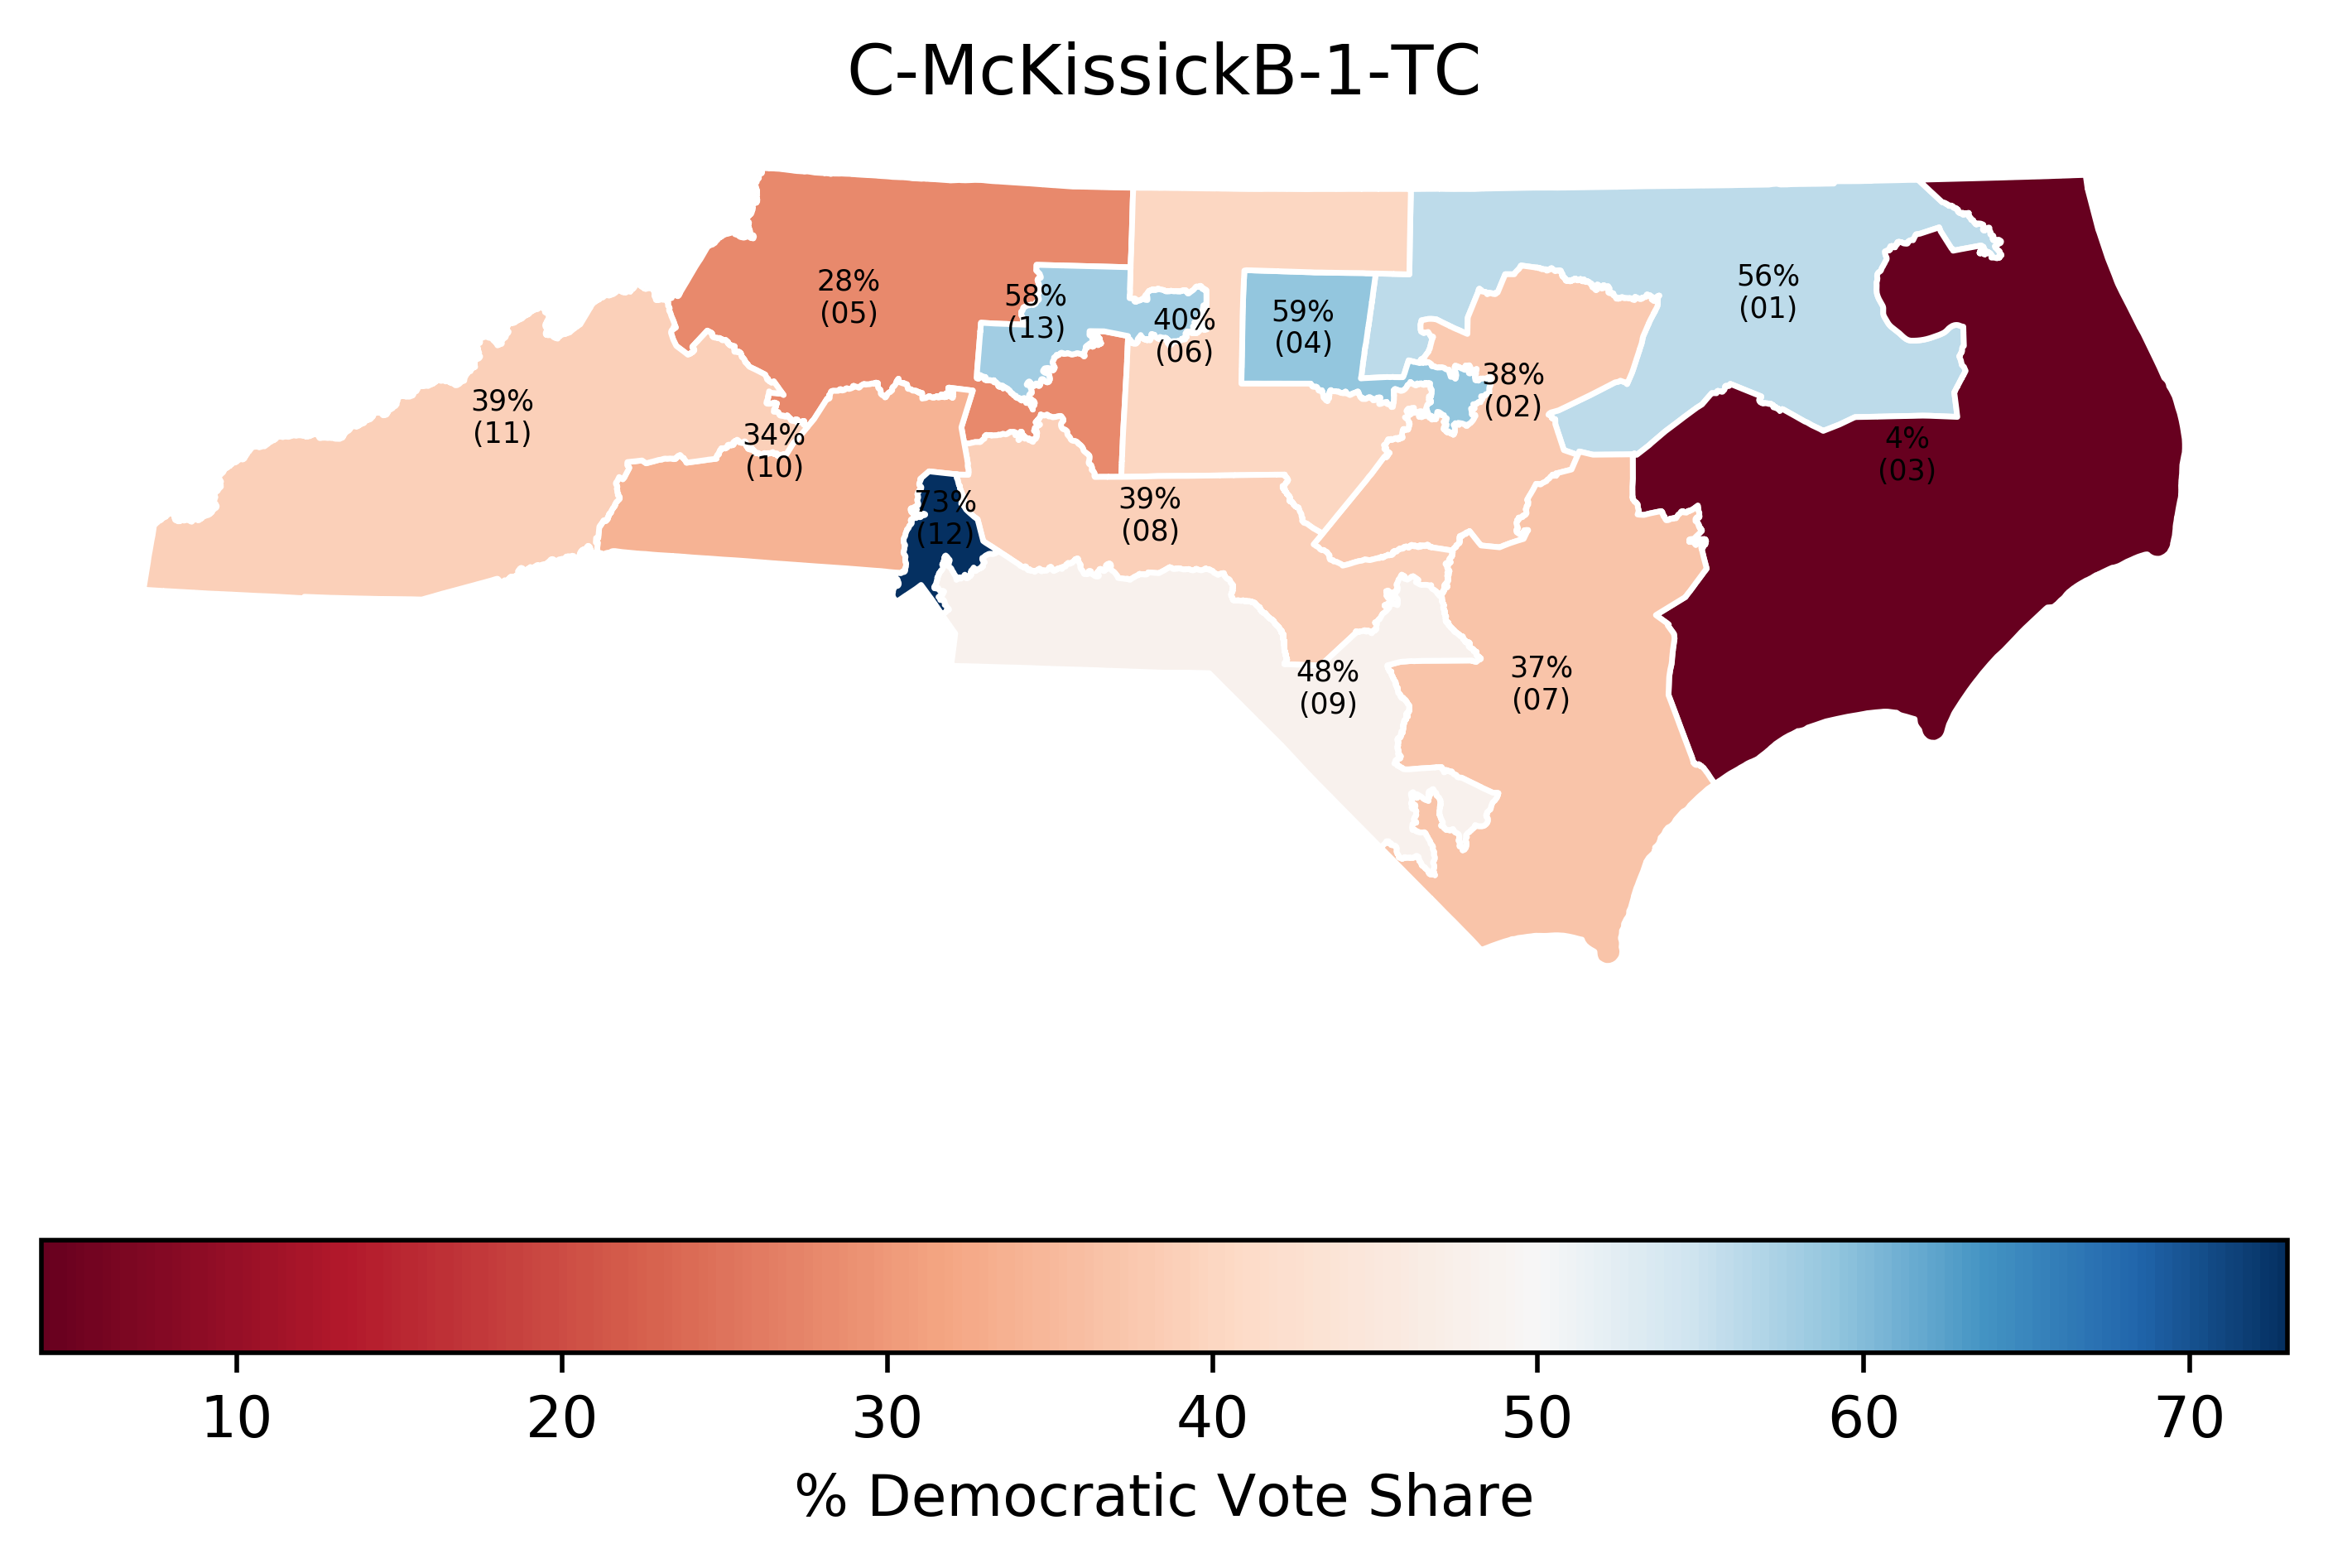

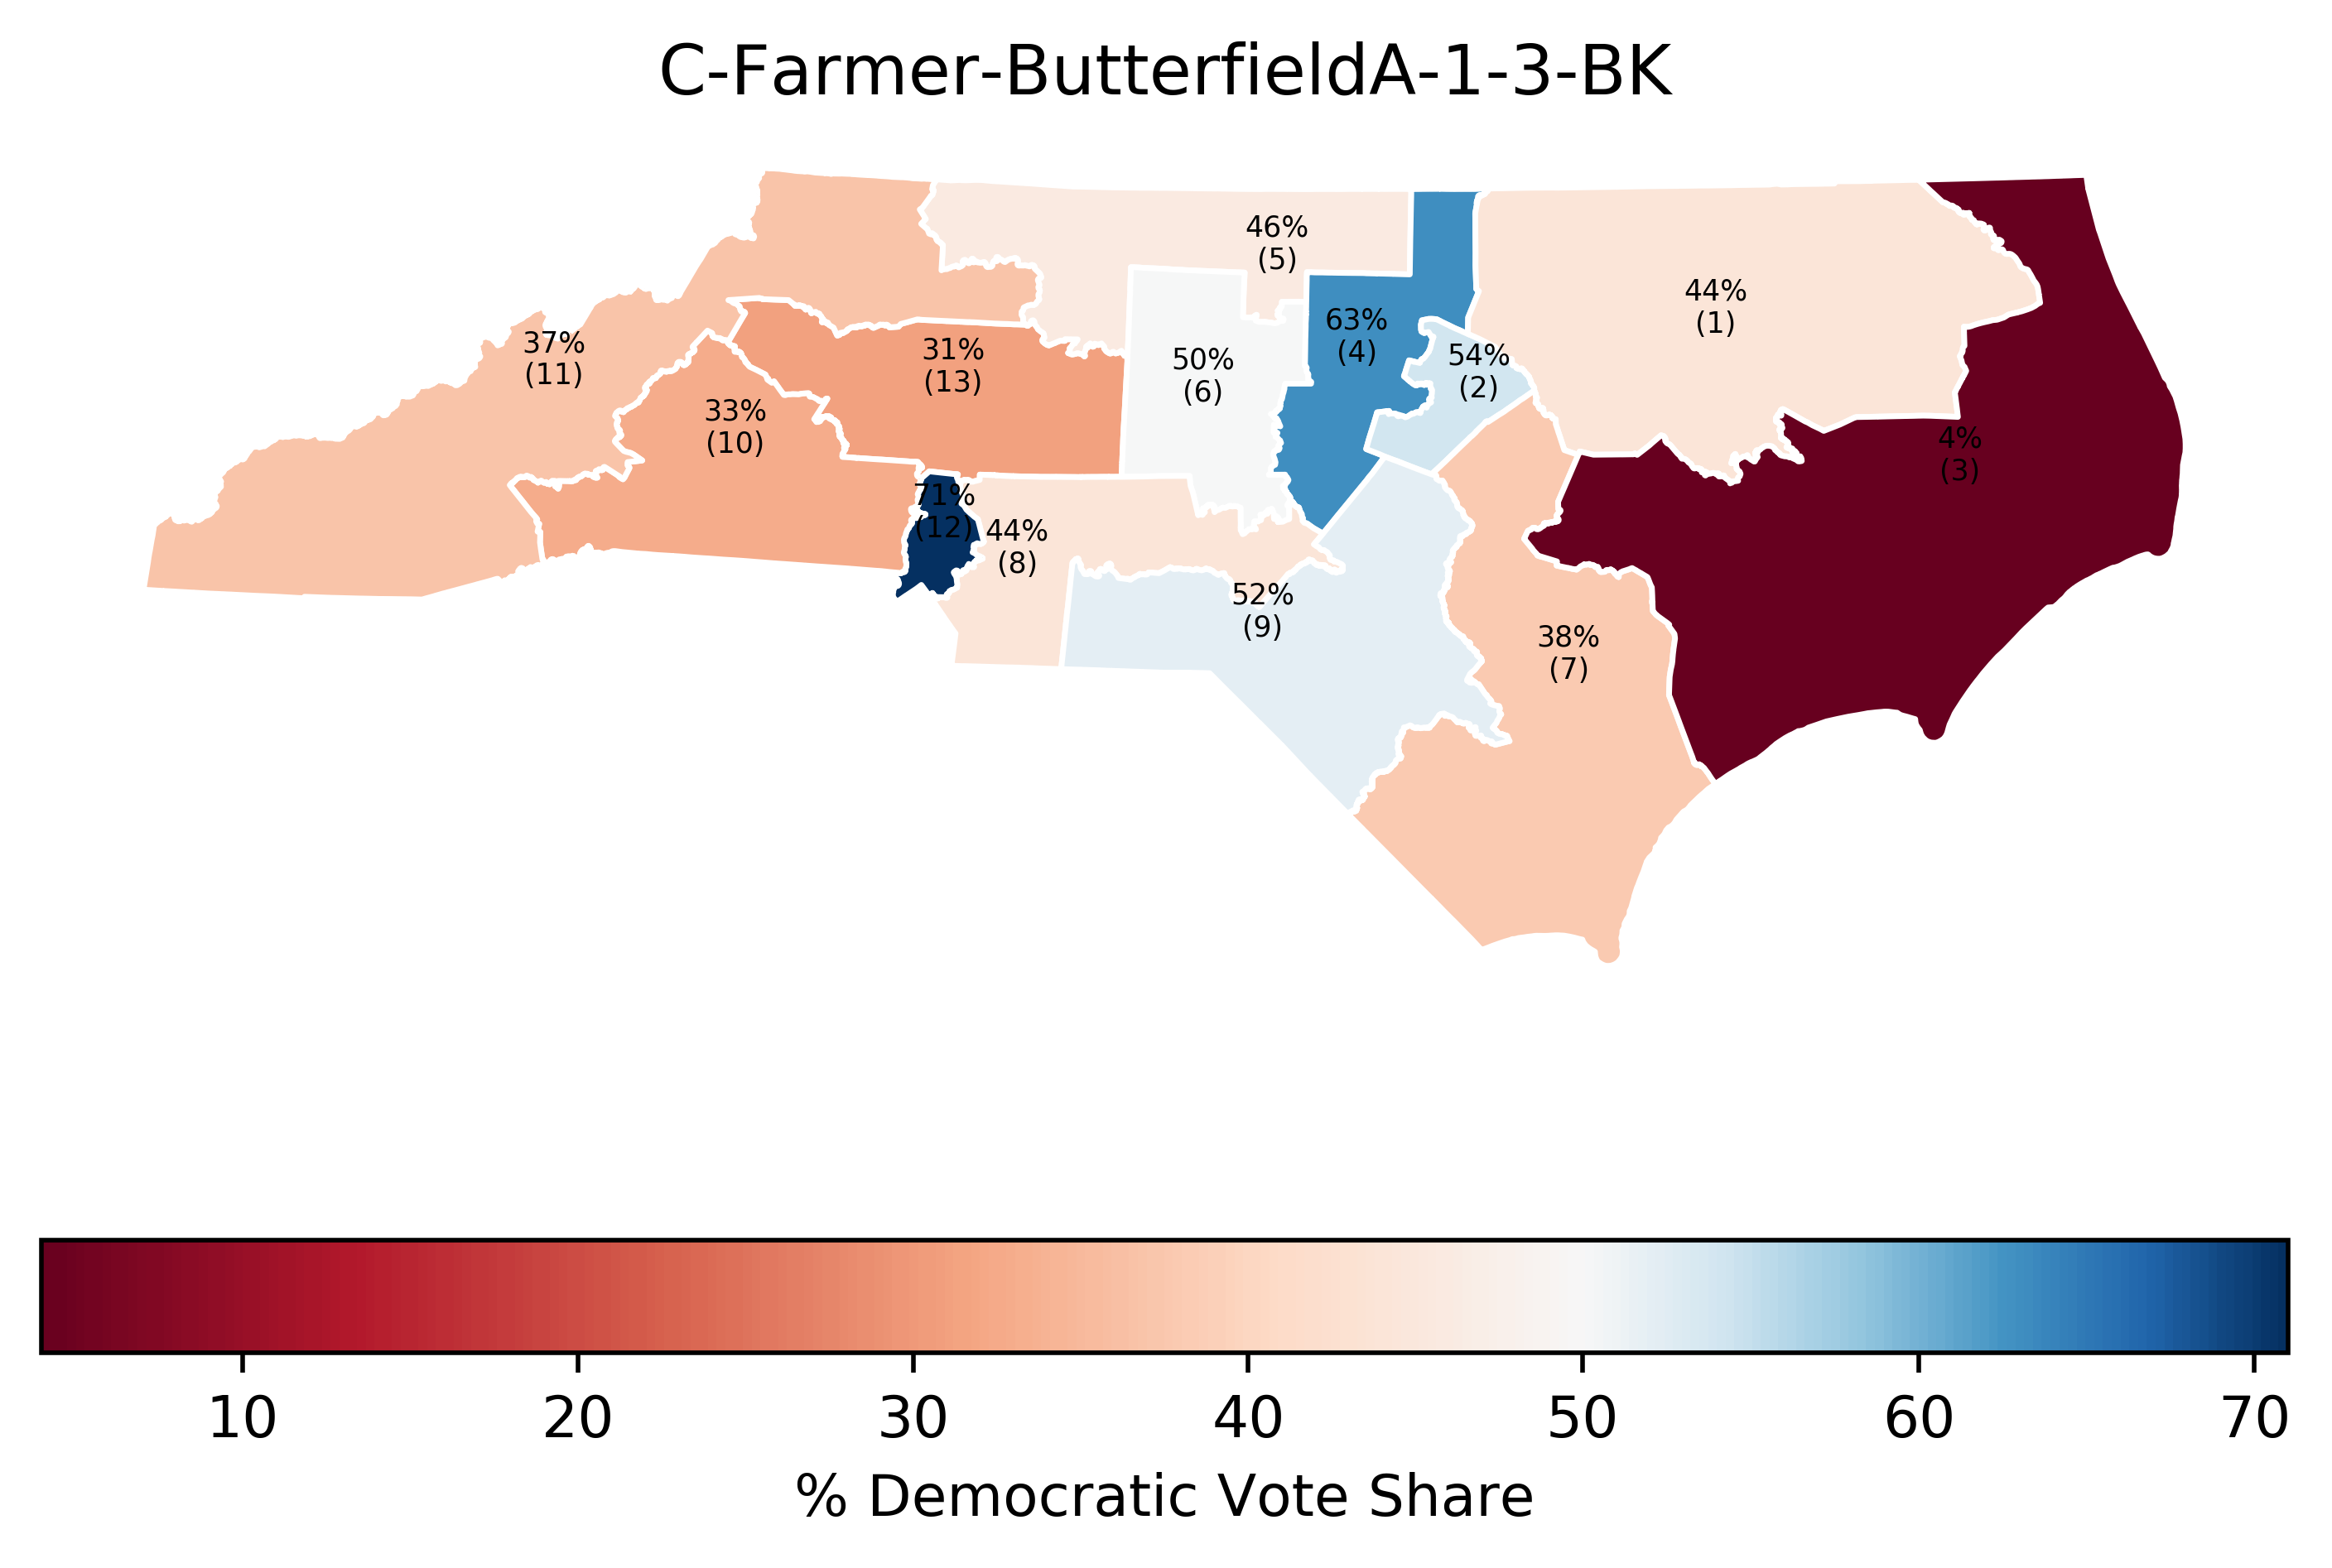

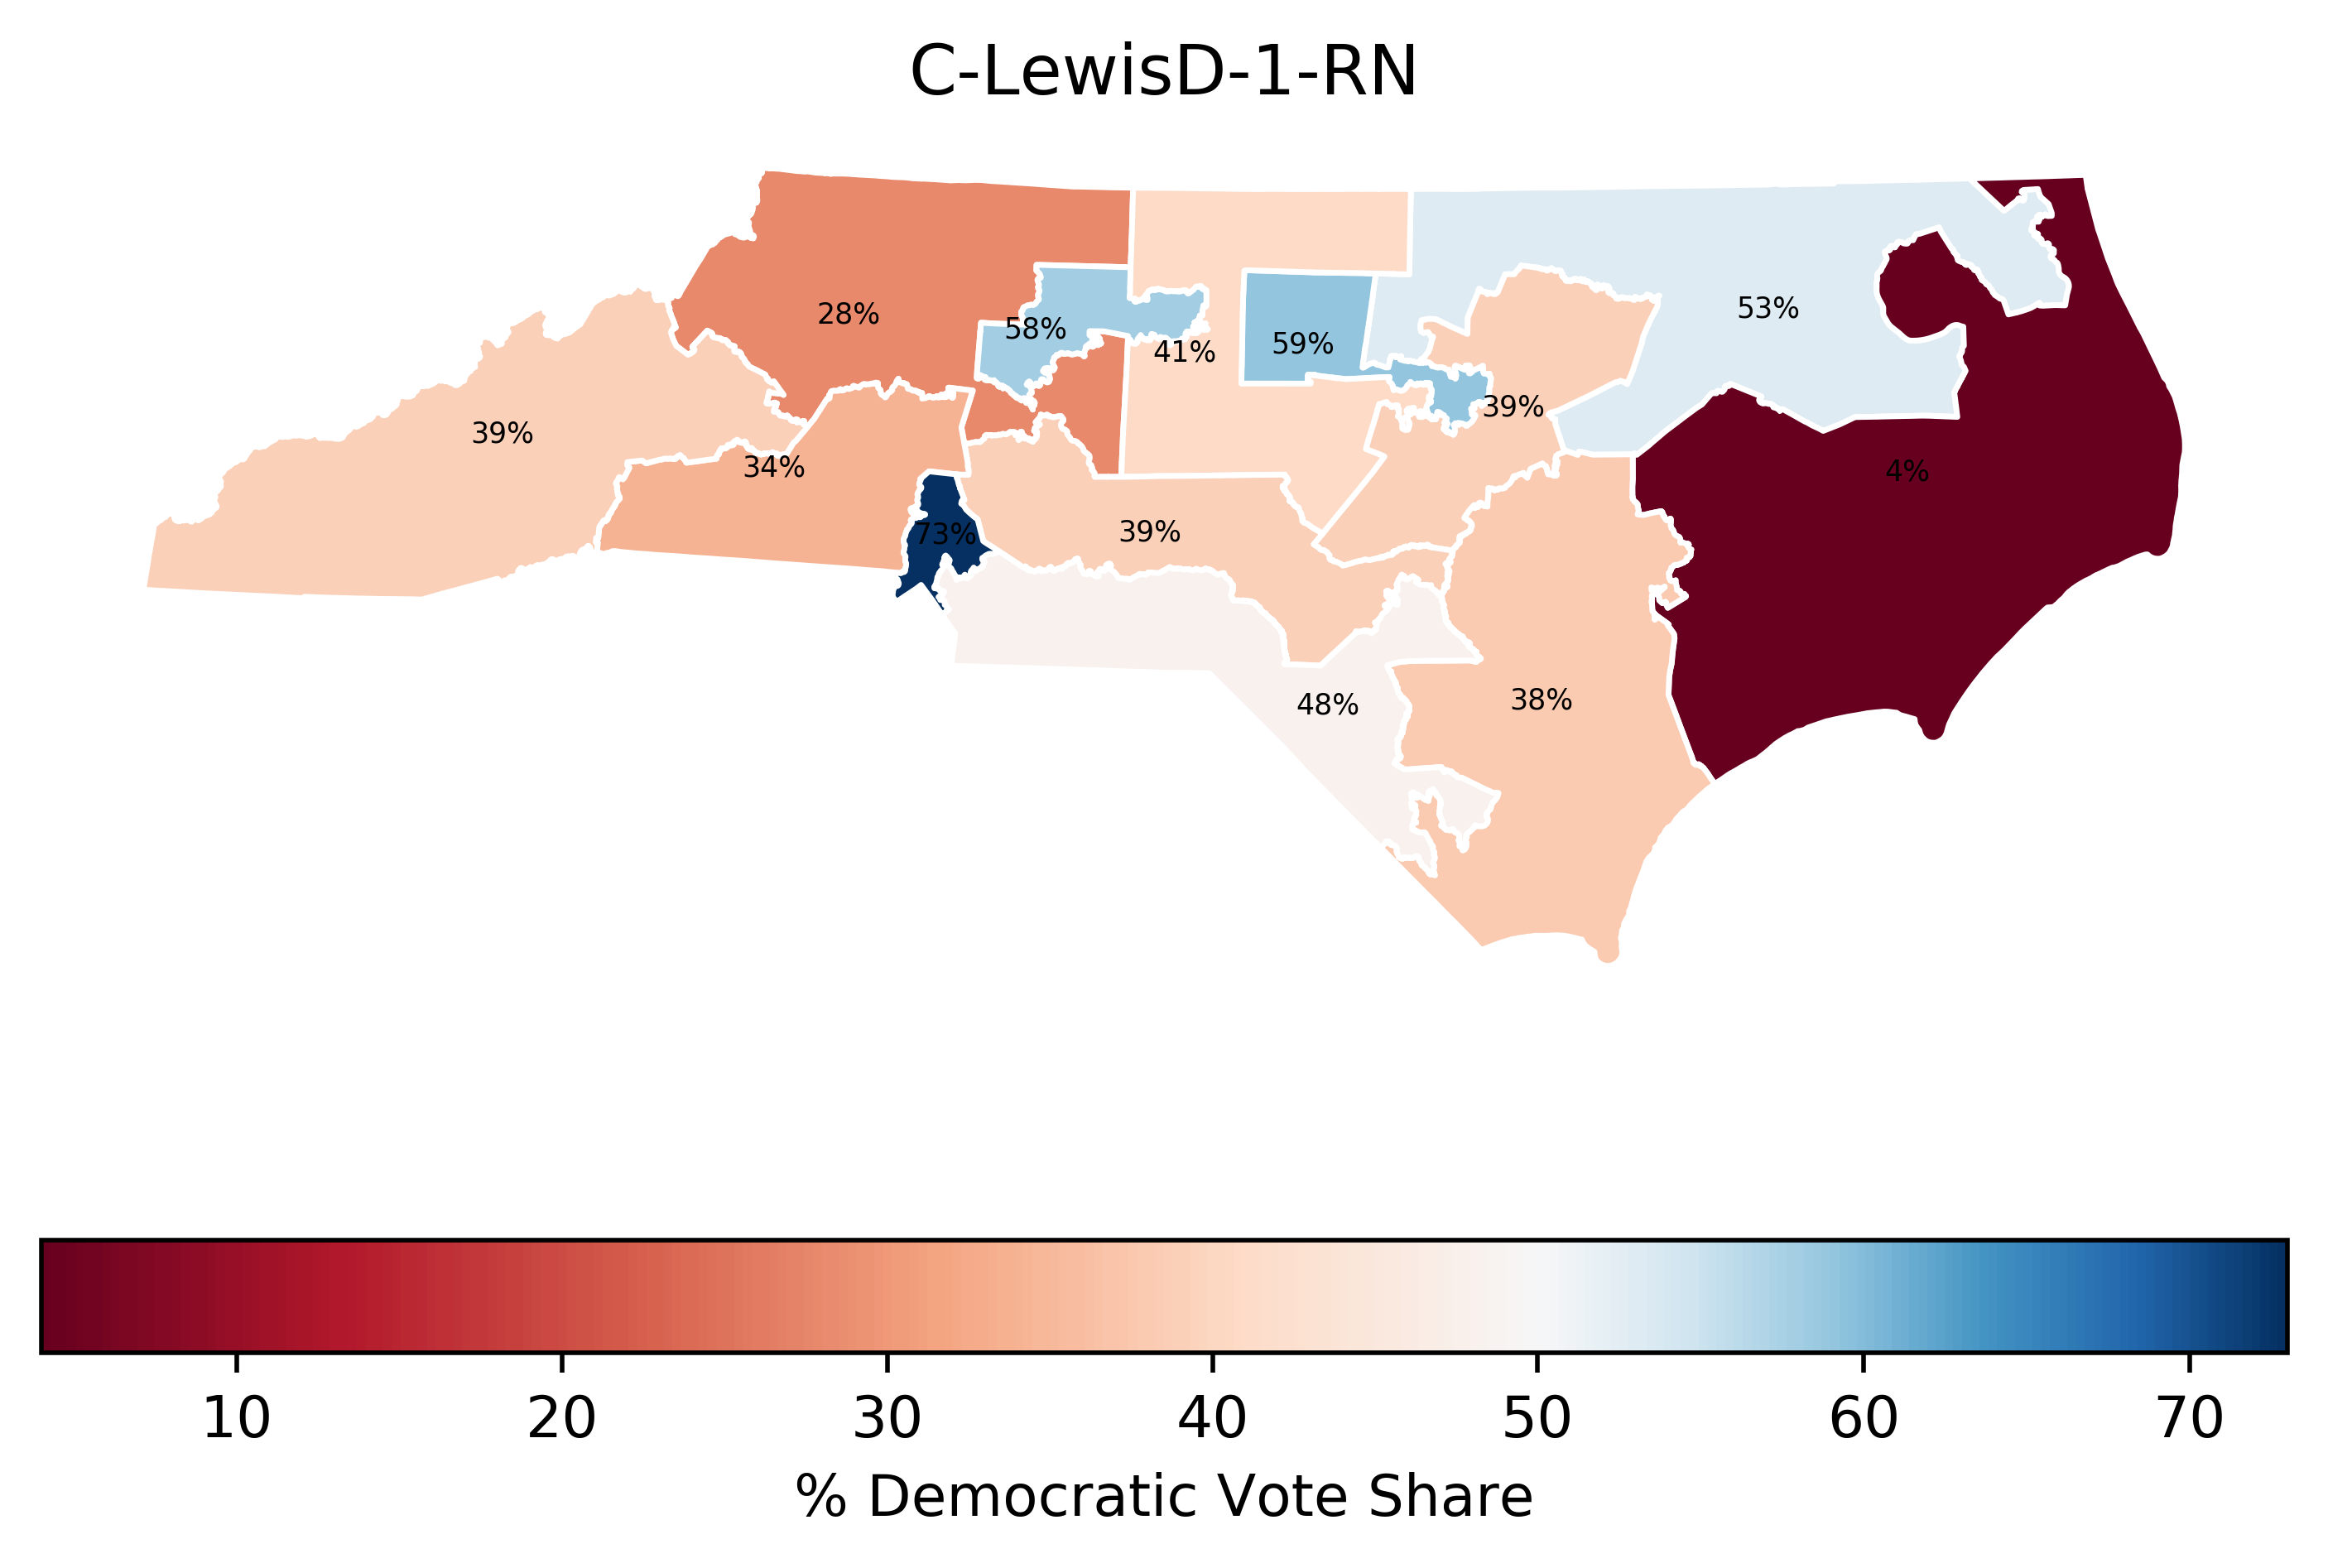

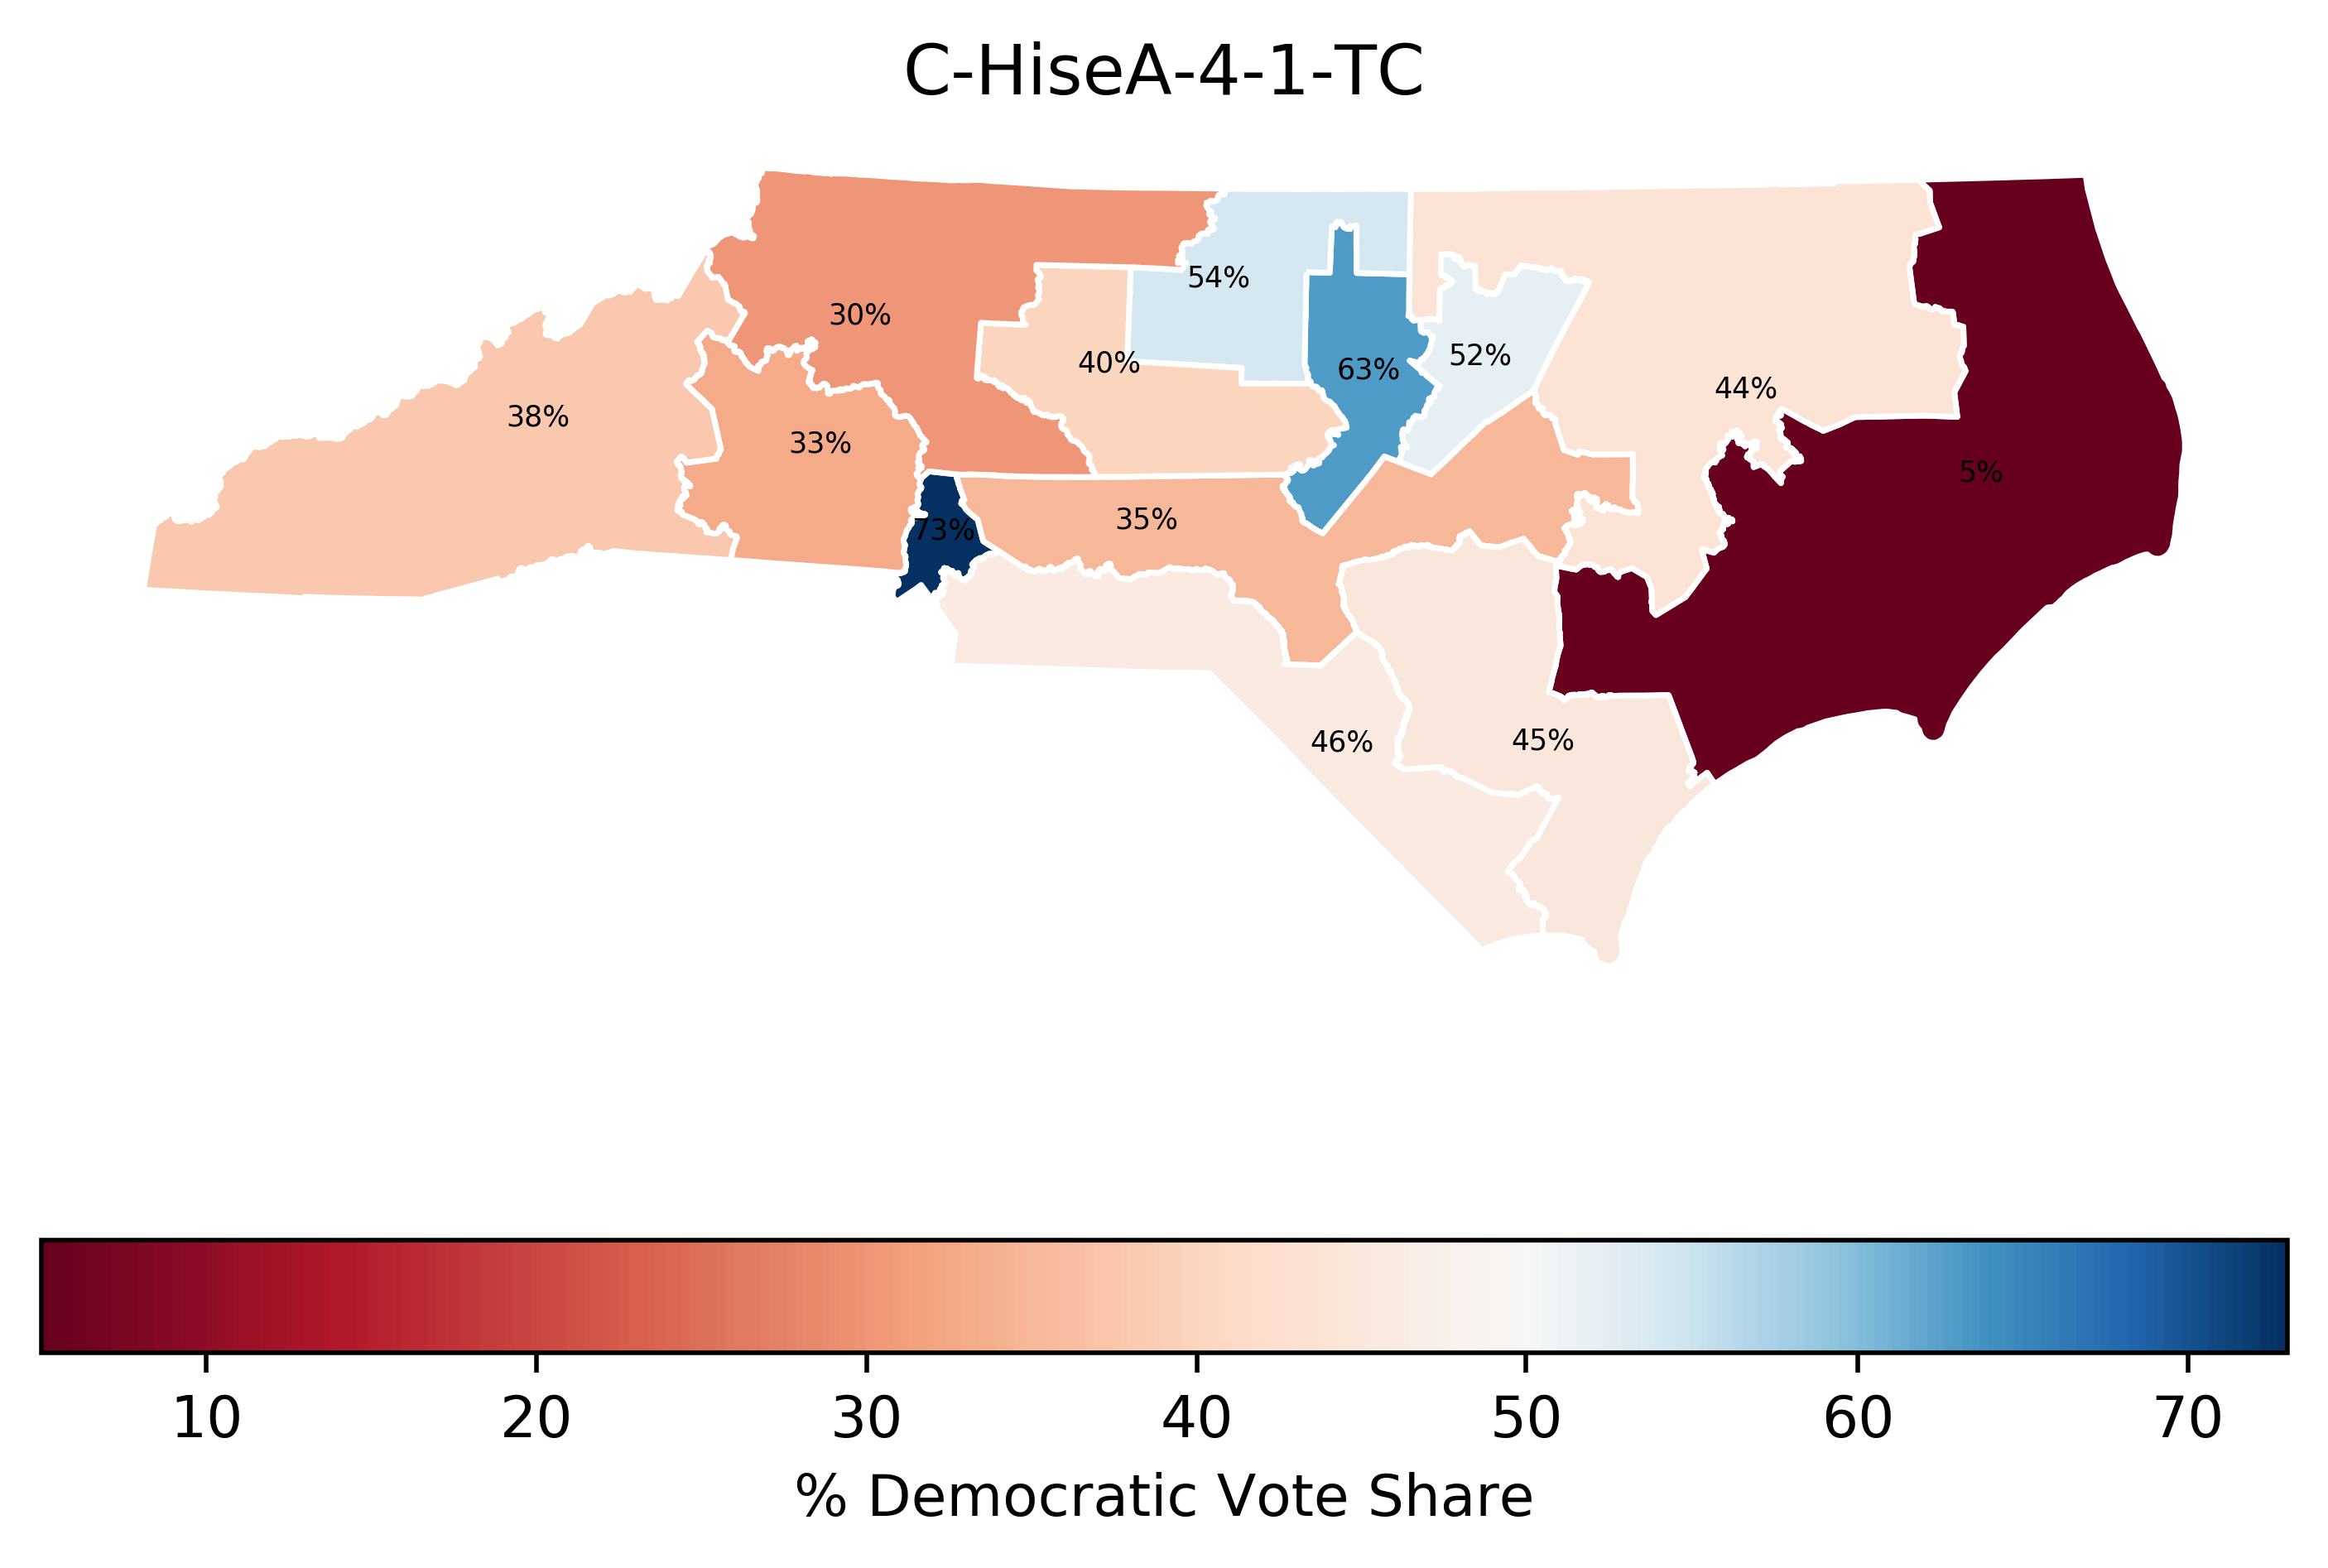

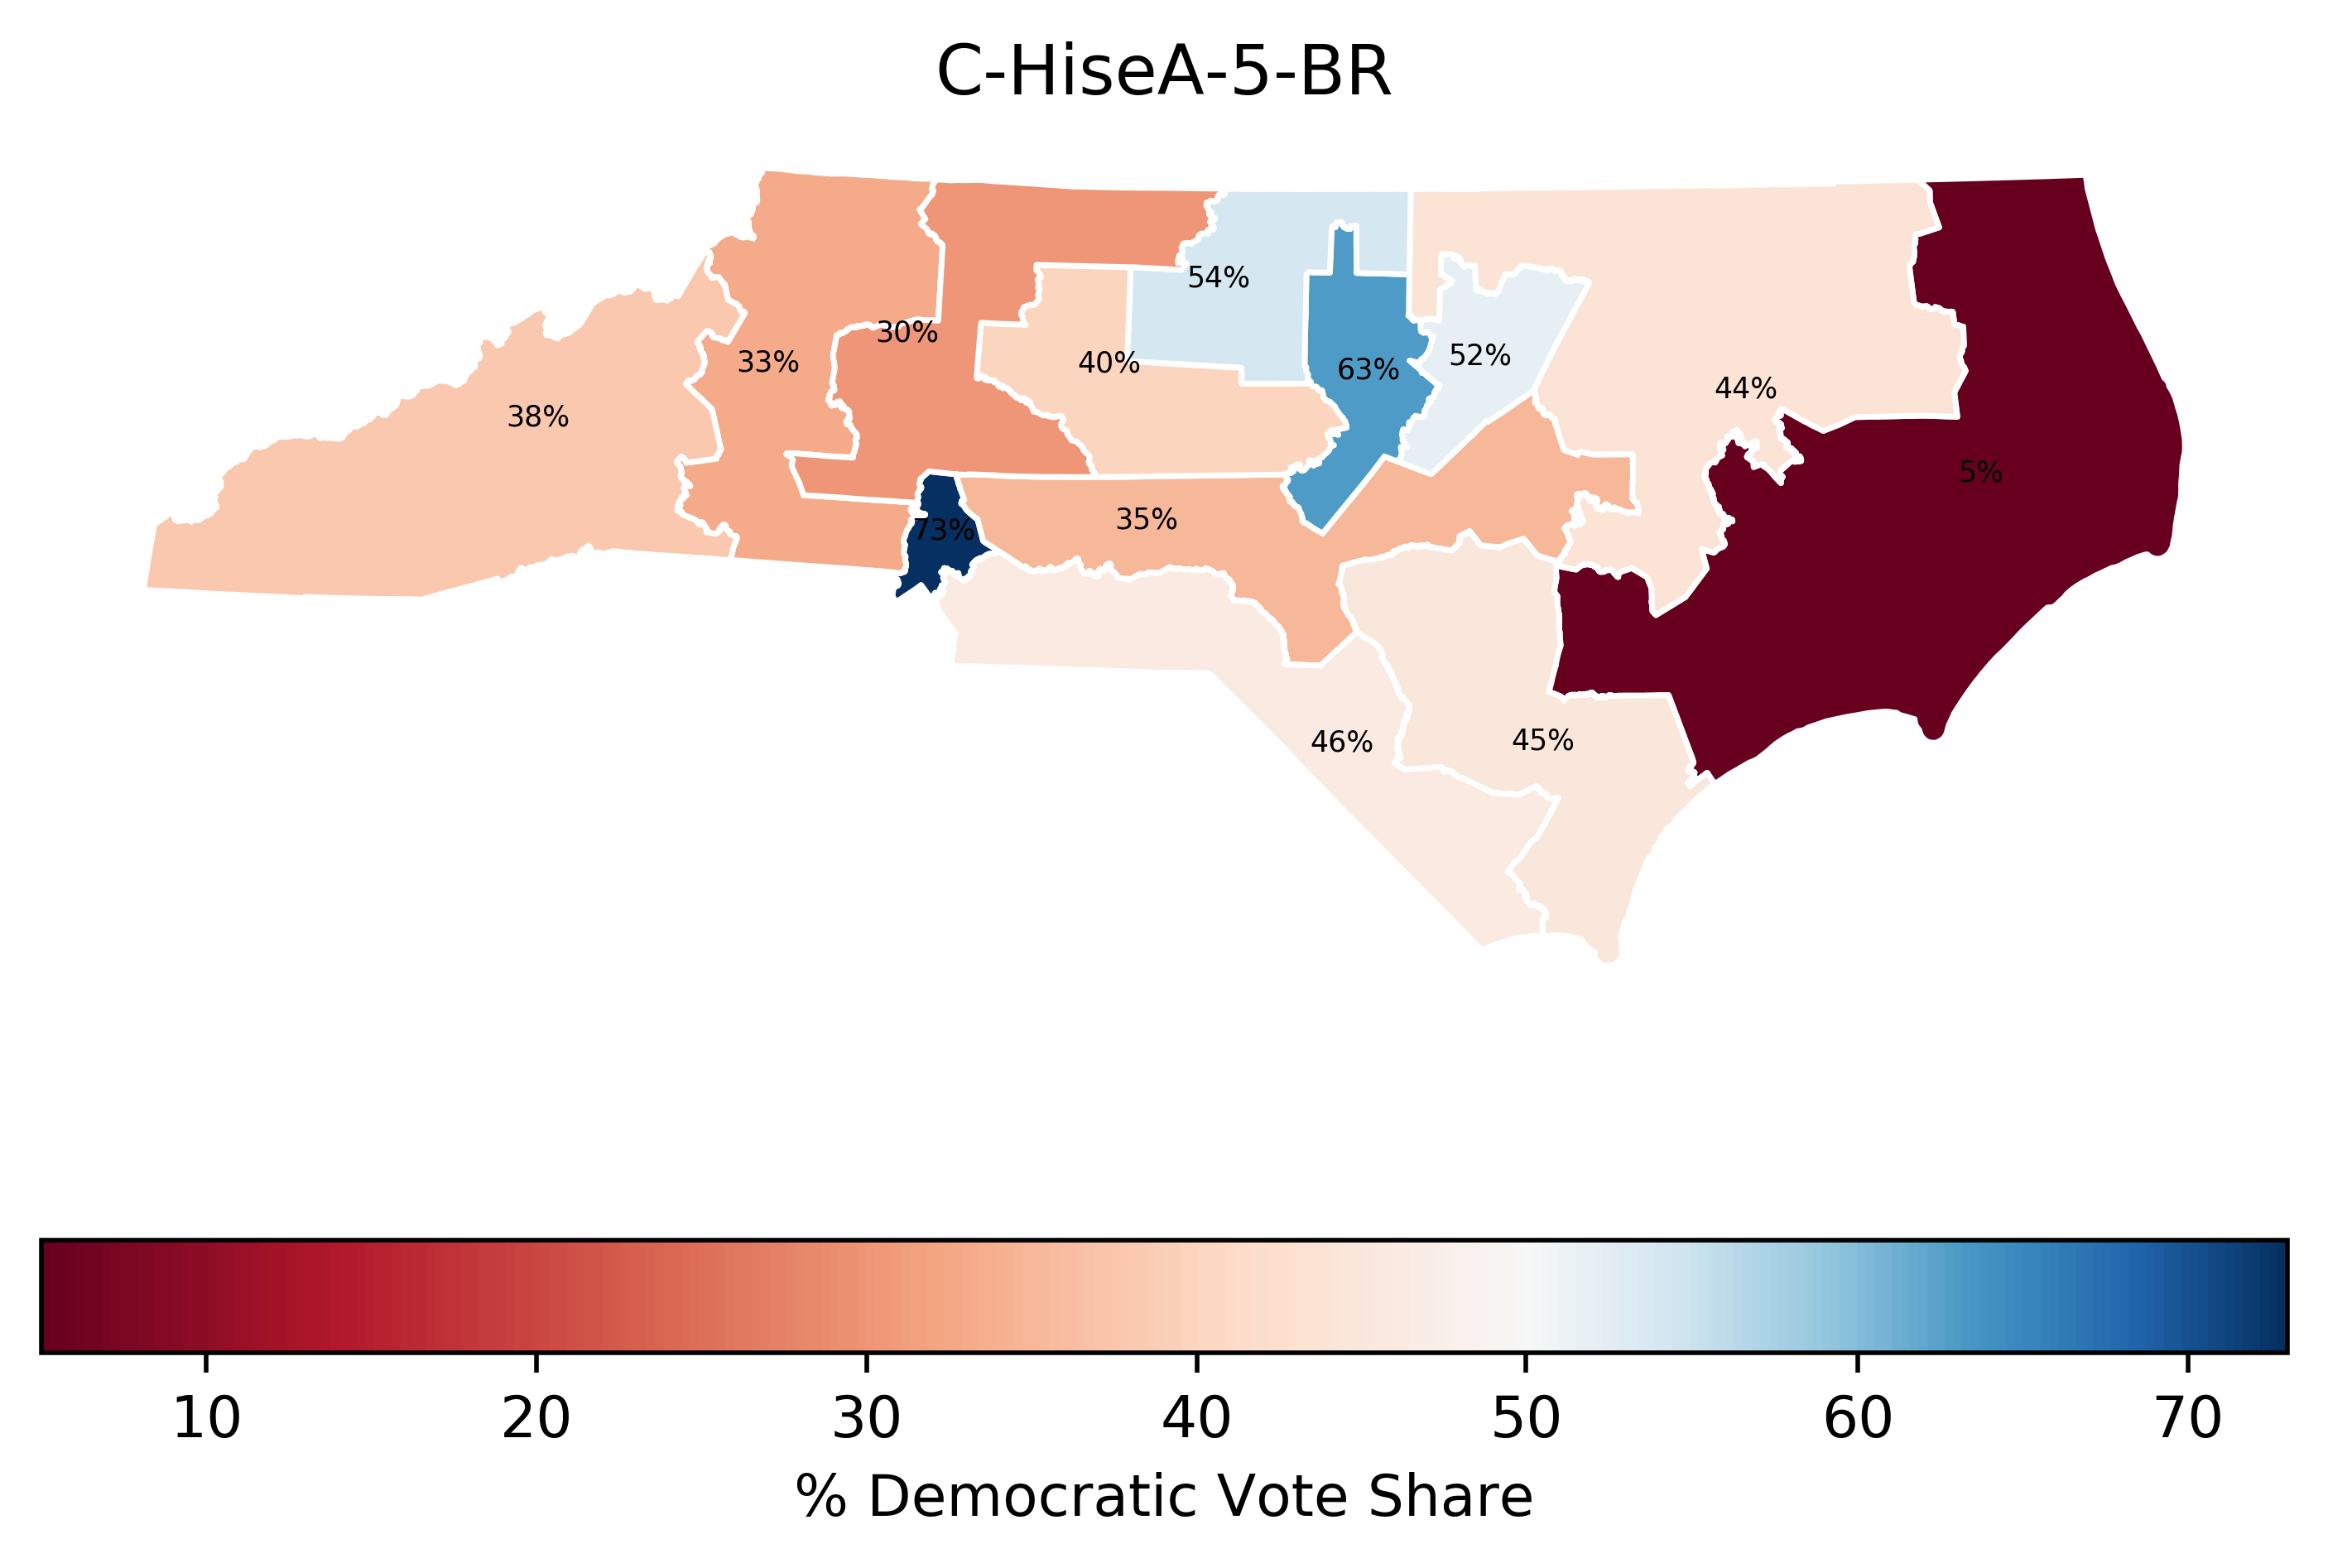

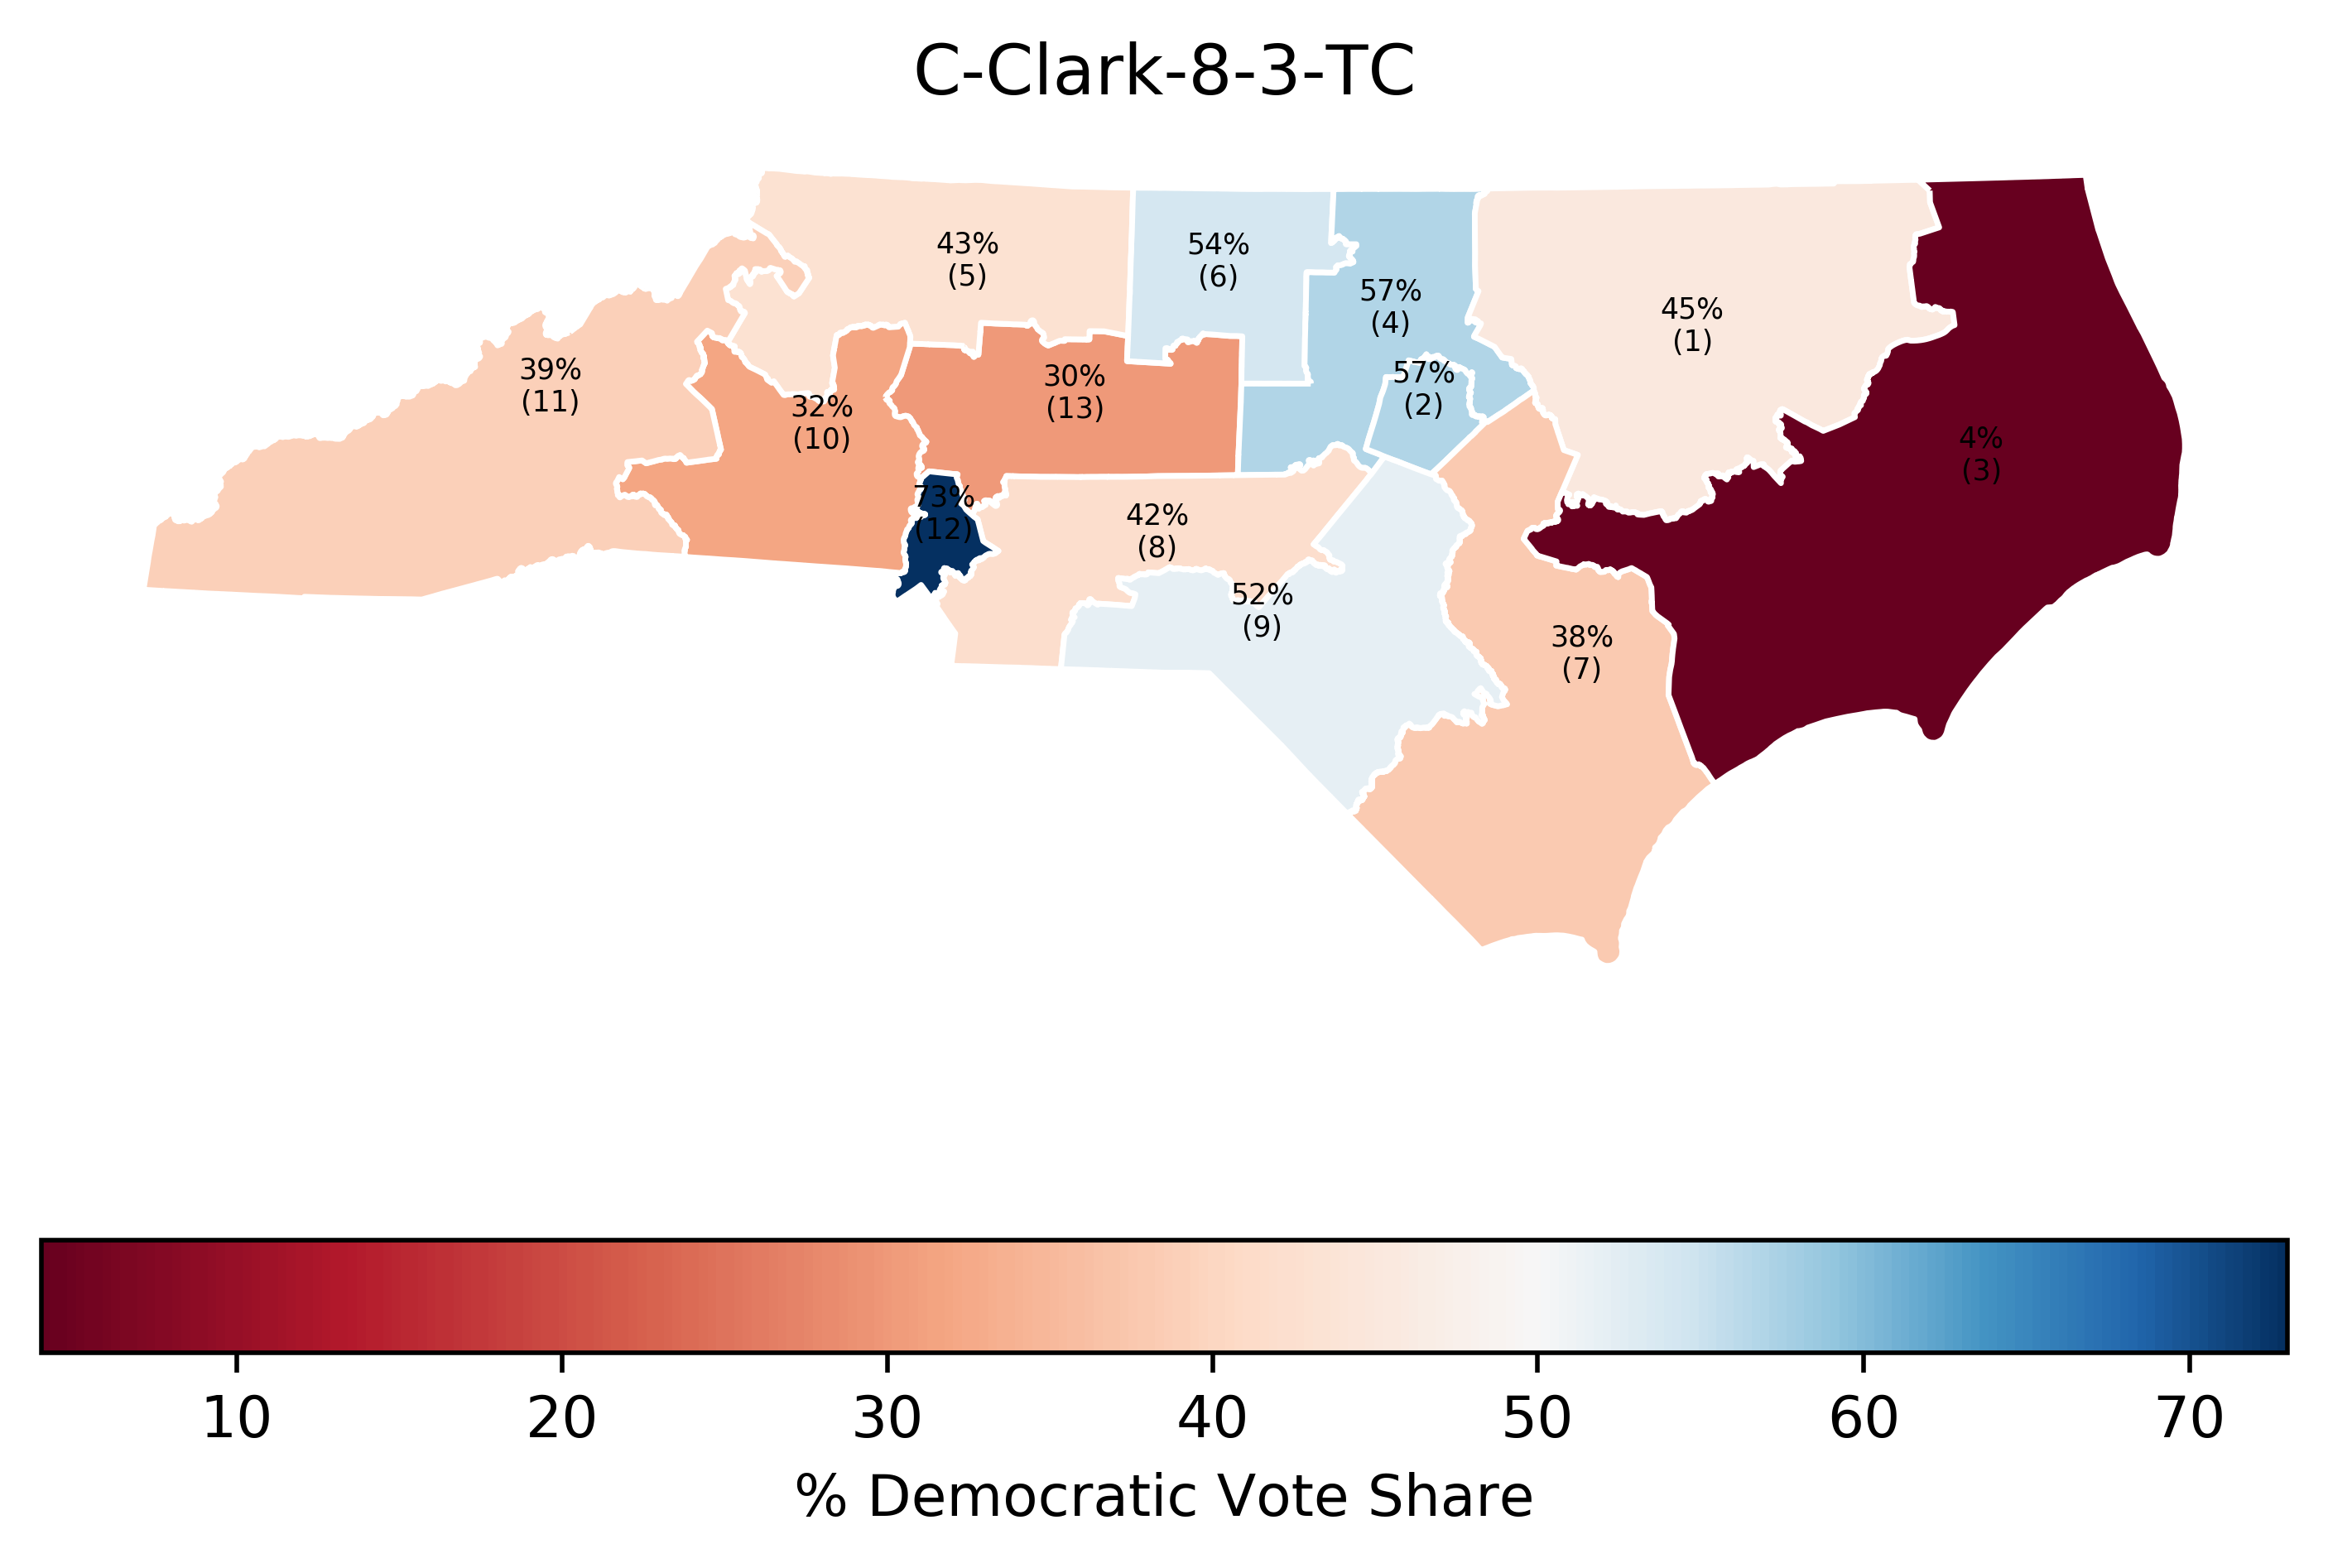

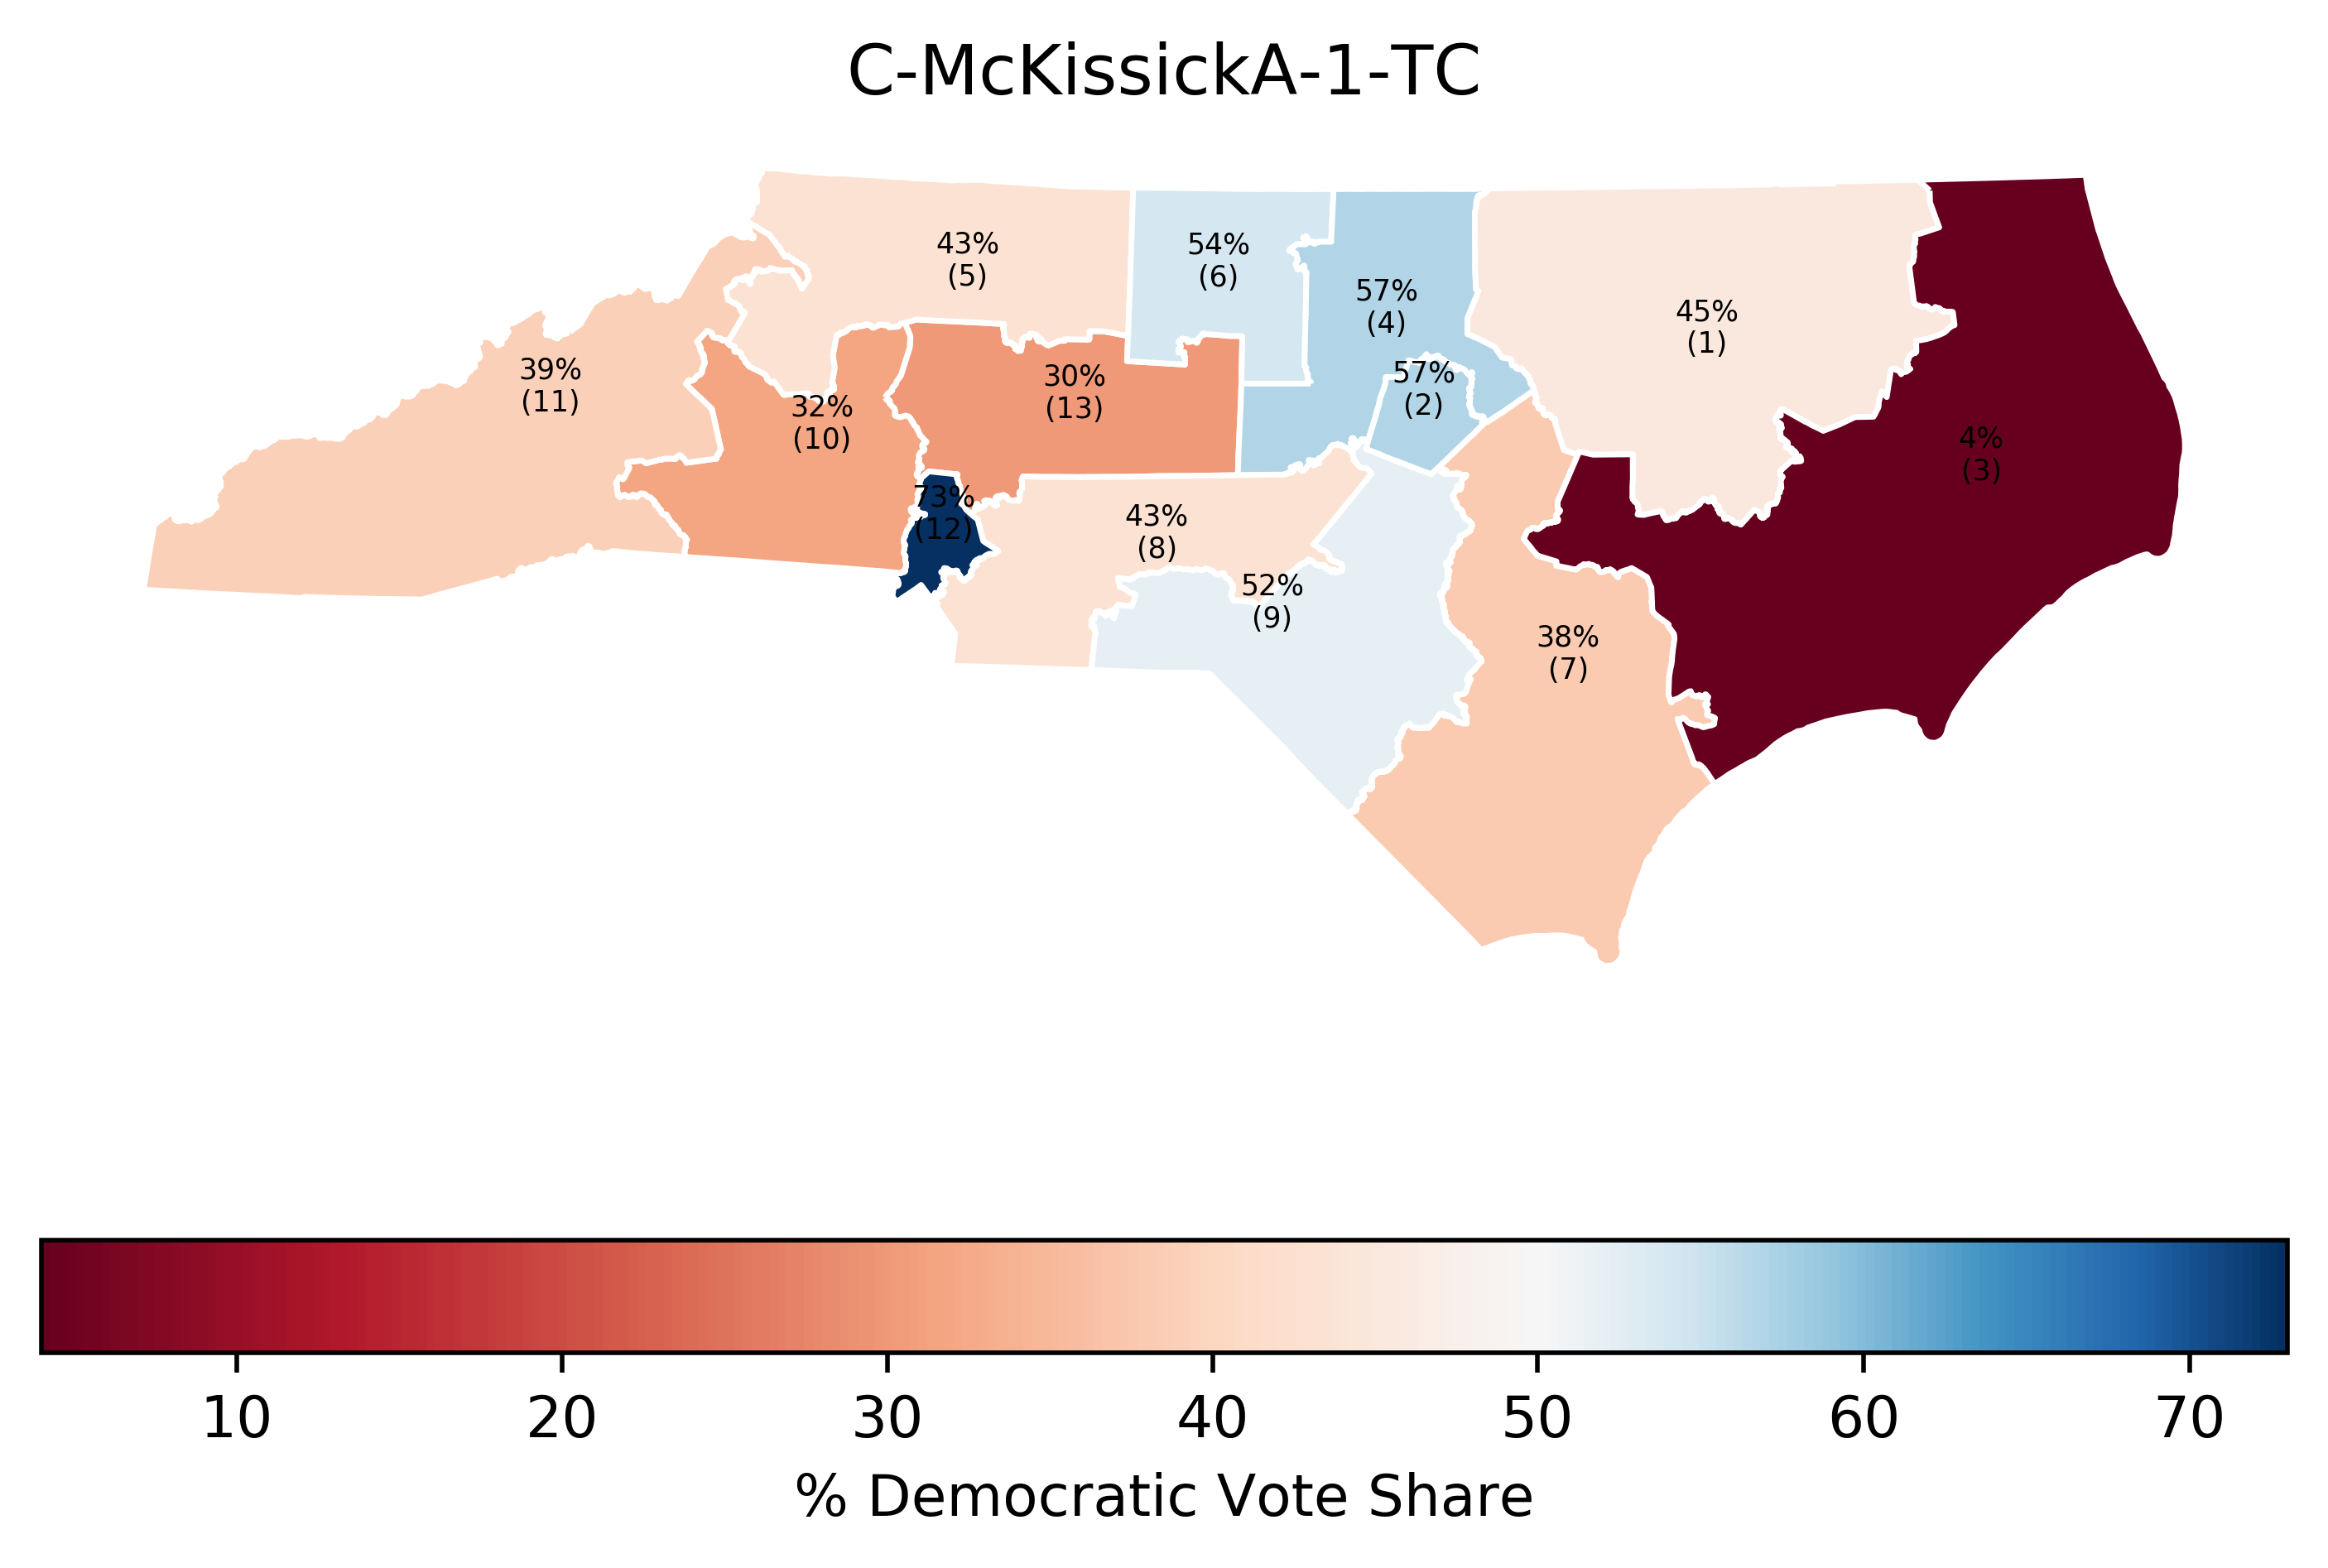

In [319]:
for key in files.keys():
    if (not key.startswith("2016")): # only the new maps
        planName = key
        plan = files[planName]
        plan["totVotes"] = plan["G18CHOR"] + plan["G18DHOR"] + plan["G18GHOR"] + plan["G18LHOR"] + plan["G18RHOR"] + plan["G18UnaHOR"]
        plan["percentDem"] = round(plan["G18DHOR"]/plan["totVotes"]*100).astype(np.int64)
        plan["percentDem_discrete"] = pd.cut(plan["percentDem"], bins=[0,15,25,35,45,55,65,75,85,100], labels=["0-15","15-25","25-35","35-45","45-55","55-65","65-75","75-85","85-100"])

        plan['coords'] = plan['geometry'].apply(lambda x: x.representative_point().coords[:])
        plan['coords'] = [coords[0] for coords in plan['coords']]

        f, ax = plt.subplots(1)
        ax.set_axis_off()
        plan.plot(column="percentDem", ax=ax, edgecolor='white', cmap='RdBu', norm=divnorm)
        for idx, row in plan.iterrows():
            label = ""
            try:
                label = str(row['percentDem'])+"%"+"\n(" + str(row['DISTRICT']) + ")"
            except:
                #print("An exception occurred")
                label = str(row['percentDem'])+"%"
            plt.annotate(s=label, xy=row['coords'], horizontalalignment='center', size=5)
        plt.title(planName)
        f.colorbar(cbar, ax=ax, label="% Democratic Vote Share", orientation='horizontal')
        plt.savefig("output/"+planName+".pdf", format="pdf")

If you took the option of saving each plot to a PDF, you can merge the files into one like to save just the plots in a file, run the following code to create a file named "NC congressional plots.pdf" that  contains all the maps.

In [10]:
# get list of all paths of plot pdfs
path = "output/"
x = [a for a in os.listdir(path) if a.endswith(".pdf")]
for i in range(len(x)):
    x[i] = path + x[i]
    
# merge all pdfs into one file
merger = PdfFileMerger()
for pdf in x:
    merger.append(open(pdf, 'rb'))

with open("./plots/NC congressional plots.pdf", "wb") as fout:
    merger.write(fout)

# Running Gerrymetrics

This section demonstrates how to apply various gerrymandering tests to the proposed plans using the code implemented in [gerrymandertests](https://github.com/PrincetonUniversity/gerrymandertests).

In [338]:
from collections import defaultdict
import gerrymetrics as g

chambers = defaultdict(lambda: defaultdict(list))
chambers['State Legislative']['filepath'] = 'election_data/state_legislative/state_legislative_election_results_post1971.csv'
chambers['Congressional']['filepath'] = 'election_data/congressional_election_results_post1948.csv'

metric_dict = {'t_test_diff':            g.t_test_diff,
               'mean_median_diff':       g.mean_median,
               'declination':            g.declination,
               'declination_buffered':   g.bdec,
               'efficiency_gap':         g.EG,
               'loss_gap':               g.EG_loss_only,
               'difference_gap':         g.EG_difference,
               'surplus_gap':            g.EG_surplus_only,
               'vote_centric_gap':       g.EG_vote_centric,
               'vote_centric_gap_two':   g.EG_vote_centric_two,
               'partisan_bias':          g.partisan_bias,
               'equal_vote_weight_bias': g.equal_vote_weight}

# impute uncontested races at a voteshare of 0 or 1; in other words, don't impute them
impute_val = 1

In [339]:
g.tests_df(g.run_all_tests(
        chambers[chamber]['elections_df'],
        impute_val=impute_val,
        metrics=metric_dict))

AttributeError: 'builtin_function_or_method' object has no attribute 'levels'

In [335]:
for chamber in chambers:
    chambers[chamber]['elections_df'] = g.parse_results(chambers[chamber]['filepath'])
    chambers[chamber]['tests_df'] = g.tests_df(g.run_all_tests(
        chambers[chamber]['elections_df'],
        impute_val=impute_val,
        metrics=metric_dict))
    chambers[chamber]['percentile_df'] = g.generate_percentiles(chambers[chamber]['tests_df'],
        metric_dict.keys(),
        competitiveness_threshold=competitiveness_threshold,
        min_districts=min_districts,
        min_year=min_year)

FileNotFoundError: [Errno 2] File b'election_data/state_legislative/state_legislative_election_results_post1971.csv' does not exist: b'election_data/state_legislative/state_legislative_election_results_post1971.csv'

# Additional analysis

In the following example, we focus on one particular map, C-Clark-9-6 RN, and look at predicted vote share for each of these districts, as predicted by __ . Instead of a gradient for the % democratic vote share, I draw a cut off line at 50% to show which party each district is predicted to win.

In [320]:
planName = "C-Clark-9-6 RN"
plan = files[planName]
plan['DISTRICT'] = pd.to_numeric(plan['DISTRICT'])
plan = plan.sort_values(by="DISTRICT")
plan["totVotes"] = plan["G18CHOR"] + plan["G18DHOR"] + plan["G18GHOR"] + plan["G18LHOR"] + plan["G18RHOR"] + plan["G18UnaHOR"]
plan["percentDem"] = round(plan["G18DHOR"]/plan["totVotes"]*100).astype(np.int64)
plan["percentDem_discrete"] = pd.cut(plan["percentDem"], bins=[0,15,25,35,45,55,65,75,85,100], labels=["0-15","15-25","25-35","35-45","45-55","55-65","65-75","75-85","85-100"])
plan["predicted_outcome"] = [54.2,57.7,36.8,67.8,39.7,53.2,39,37.4,50.5,29.6,40.4,68,28.3]
plan['predicted_outcome_discrete'] = np.where(plan['predicted_outcome']>50, 1, 0)

Here I also wanted to add a star on four major NC cities.

In [321]:
# When entering the lat and long, must convert from the 
# standard EPSG:4326 (world) to EPSG:2264 (north carolina)
# using https://epsg.io/transform#s_srs=4326&t_srs=2264&x=-79.7662350&y=36.0446590
cities = pd.DataFrame(
    {'City': ['Raleigh', 'Winston-Salem', 'Charlotte', 'Greensboro'],
     #'Latitude': [35.787743, 36.099861, 35.227085, 36.044659], # original values before conversion
     #'Longitude': [-78.644257, -80.244217, -80.843124, -79.766235]})
     'Latitude': [741824.09942807, 857554.28686612, 542683.74598832, 836029.61056668],
     'Longitude': [2105505.26701455, 1632426.44441380, 1449613.12898106, 1773475.77697019]})

geometry = [Point(xy) for xy in zip(cities['Longitude'], cities['Latitude'])]
cities_gdf = gpd.GeoDataFrame(cities, geometry=geometry, crs = {'init' :'epsg:2264'})

In [322]:
import matplotlib as mpl
thiscmap = mpl.colors.ListedColormap(['red', 'blue'])
bounds = [0,50,100]
norm = mpl.colors.BoundaryNorm(bounds, thiscmap.N)

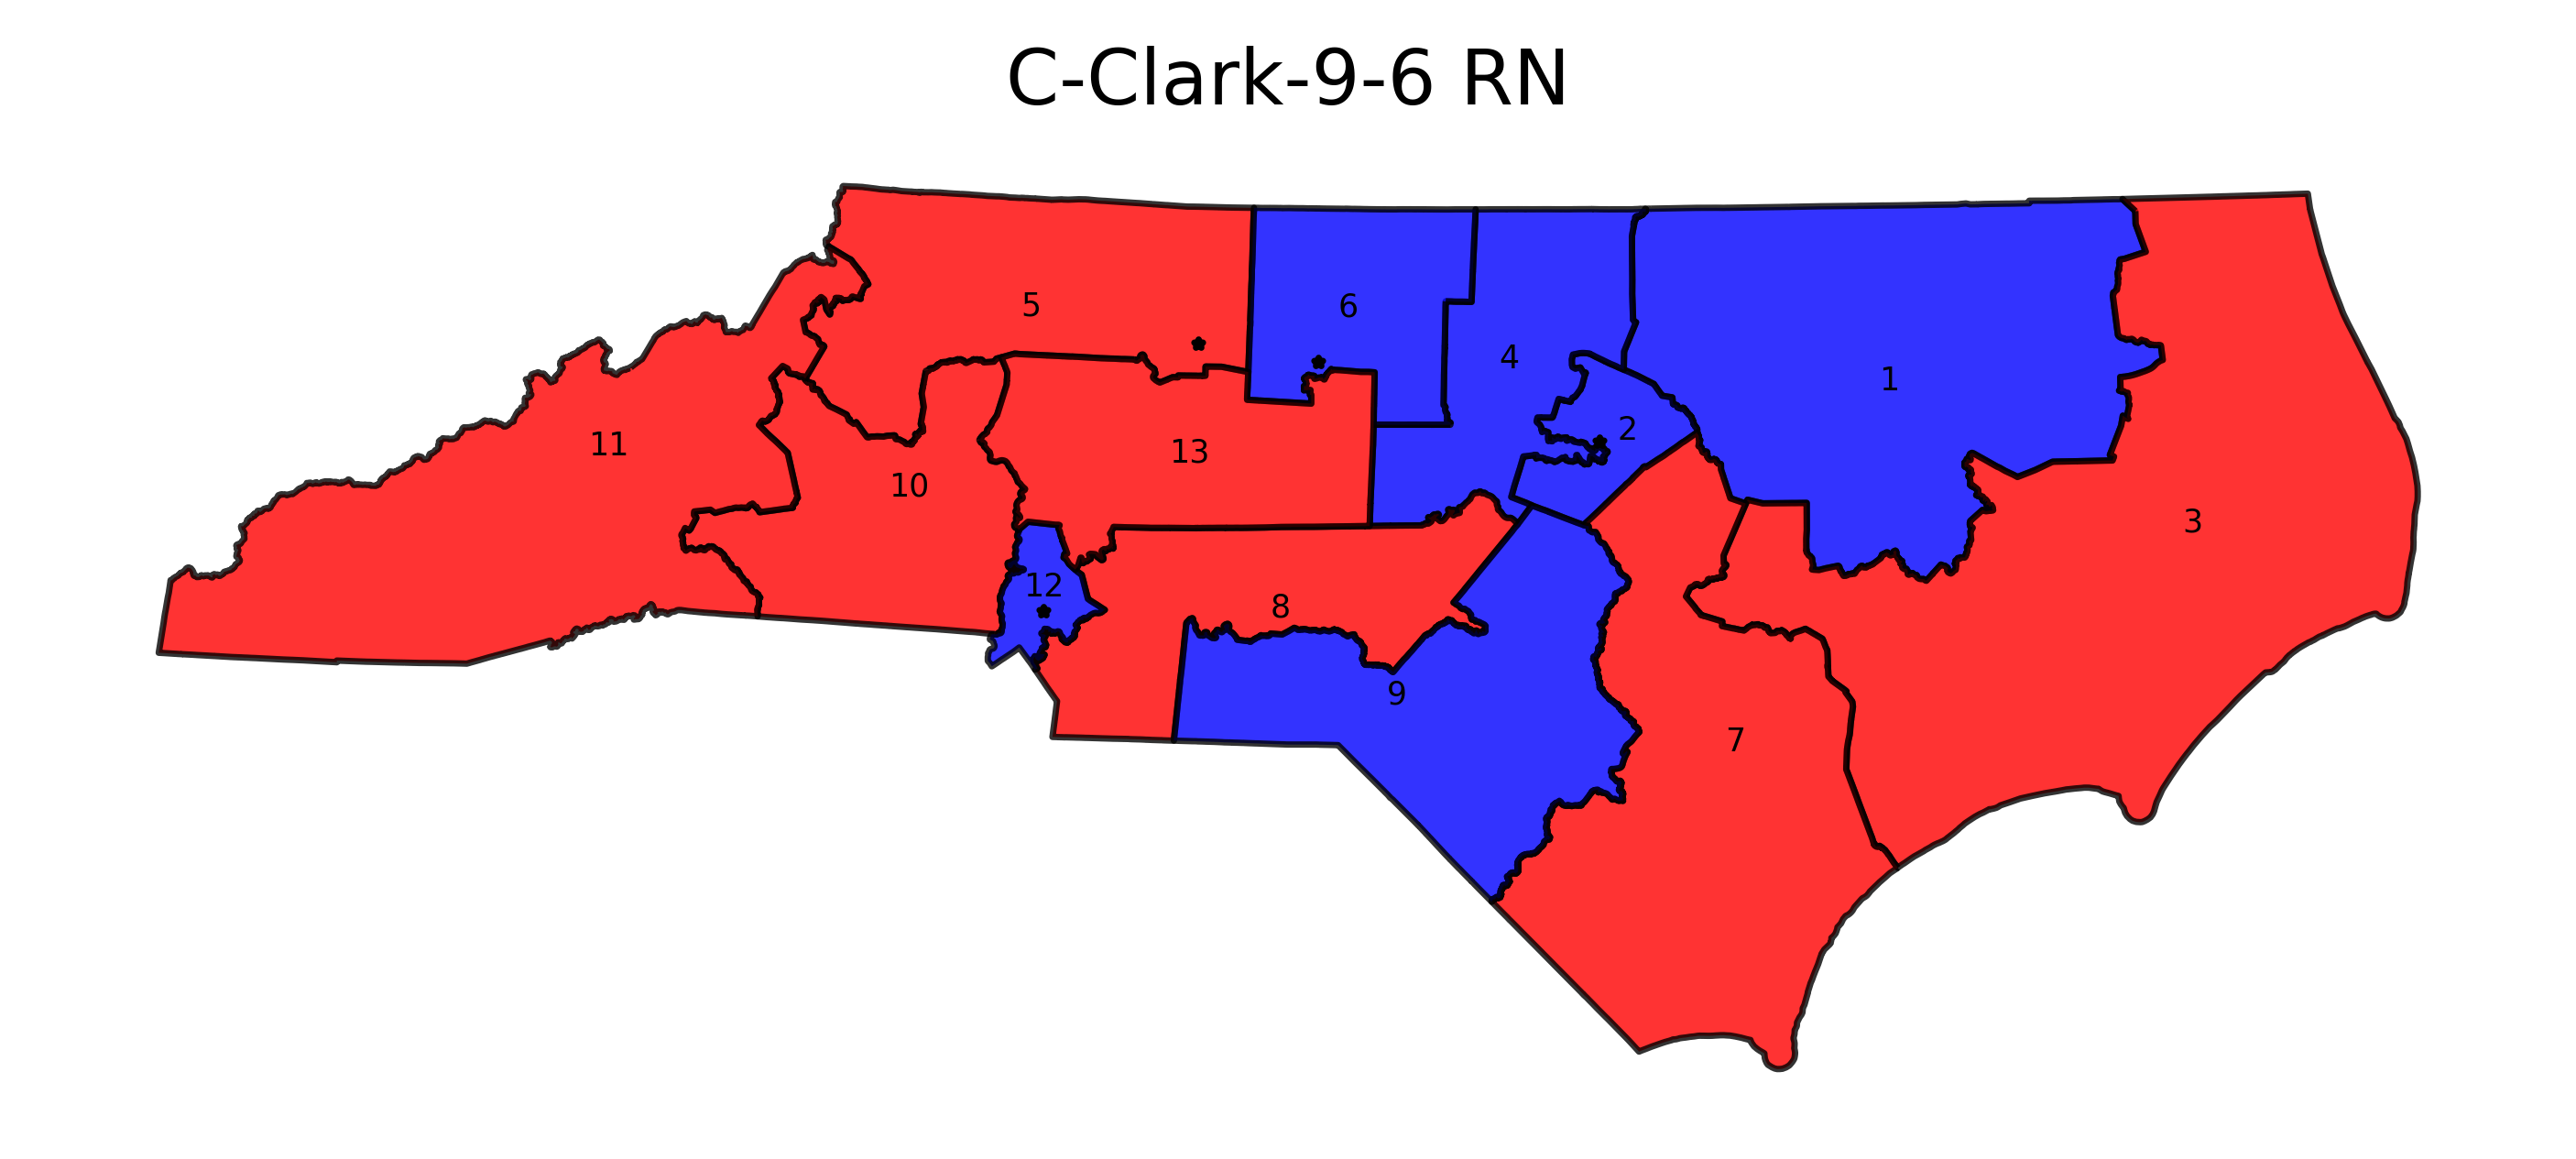

In [323]:
plan['coords'] = plan['geometry'].apply(lambda x: x.representative_point().coords[:])
plan['coords'] = [coords[0] for coords in plan['coords']]

f, ax = plt.subplots(1)
ax.set_axis_off()
plan.plot(column="predicted_outcome", ax=ax, edgecolor='black', cmap=thiscmap, norm=norm, alpha=.8)
for idx, row in plan.iterrows():
    plt.annotate(s=row['DISTRICT'], xy=row['coords'], horizontalalignment='center', size=5) #str(row['predicted_outcome'])+"%"

cities_gdf.plot(ax=ax, marker='*', color='k', markersize=2)

plt.title(planName)
plt.show()